# 기본 세팅

### Library Import

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from statsmodels.tsa.stattools import ccf
from sklearn.preprocessing import StandardScaler

### Data Load

In [2]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 29.91it/s]


# EDA (Explanatory Data Analysis)

## 0. 결측치

In [4]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
sorted_missing_percentage

hourly_market-data_open-interest_ftx_all_symbol_open_interest                100.0
hourly_market-data_liquidations_okex_btc_usd_long_liquidations               100.0
hourly_market-data_liquidations_okex_btc_usd_short_liquidations              100.0
hourly_market-data_open-interest_ftx_open_interest                           100.0
hourly_market-data_open-interest_okex_open_interest                          100.0
                                                                             ...  
hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd      0.0
hourly_market-data_open-interest_htx_global_btc_usd_open_interest              0.0
_type                                                                          0.0
target                                                                         0.0
ID                                                                             0.0
Length: 255, dtype: float64

In [5]:
# 100% missing은 뭐지 40개나 있네
missing100 = sorted_missing_percentage[sorted_missing_percentage == 100]
len(missing100)

40

In [6]:
# 결측치 100 컬럼 삭제
df.drop(columns = missing100.index, inplace = True)

In [7]:
# 160개 변수에 결측치 발생 (1% 정도)
sorted_missing_percentage[(sorted_missing_percentage > 0) & (sorted_missing_percentage < 100)]

hourly_market-data_open-interest_binance_btc_busd_open_interest               1.004566
hourly_market-data_liquidations_binance_btc_busd_short_liquidations           1.004566
hourly_market-data_liquidations_binance_btc_busd_long_liquidations            1.004566
hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd        1.004566
hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd       1.004566
                                                                                ...   
hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations_usd    0.011416
hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations_usd     0.011416
hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations        0.011416
hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations         0.011416
hourly_market-data_liquidations_gate_io_all_symbol_short_liquidations         0.011416
Length: 160, dtype: float64

- 여기서 필요 없는 변수들 많은 듯
- 없앨 변수는 없애고, 남은 변수들은 mice 등을 통해 처리해보자.

## 1. target 탐색
- target : 이전 시점 대비 다음 시점에서의 종가(PRICE-OHLCV의 close)의 등락 percentage 4가지 class

|class |description       |count  |
|------|------------------|-------|
| 0    | -0.5% 미만        | 740   |
| 1    | -0.5% 이상 0% 미만 | 3544  |
| 2    | 0% 이상 0.5% 미만  | 3671  |
| 3    | 0.5% 이상         | 805   |
|------|------------------|-------|
|total |                  | 8760  |

In [8]:
file_name = 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD' # 모든 거래소에서의 비트코인 OHLCV 데이터
col_name = 'close' # 종가 변수
col = file_name.lower() + '_' + col_name
y = df[['ID', 'target', col]].rename(columns = {col : 'close'})
y = y[y.ID < '2024-01-01'] # 2024년은 test 데이터
y

ID  target         close
0     2023-01-01 00:00:00     2.0  16536.747967
1     2023-01-01 01:00:00     1.0  16557.136536
2     2023-01-01 02:00:00     1.0  16548.149805
3     2023-01-01 03:00:00     1.0  16533.632875
4     2023-01-01 04:00:00     2.0  16524.712159
...                   ...     ...           ...
8755  2023-12-31 19:00:00     1.0  42597.709522
8756  2023-12-31 20:00:00     1.0  42535.570787
8757  2023-12-31 21:00:00     0.0  42497.523419
8758  2023-12-31 22:00:00     2.0  42257.026218
8759  2023-12-31 23:00:00     2.0  42285.799905

[8760 rows x 3 columns]

In [9]:
y['close_prev'] = y['close'].shift(1) # 이전 시점 close 변수 생성
y['target2'] = (y['close'] - y['close_prev'])/y['close_prev'] * 100 # (현재 시점 close - 이전 시점 close) / 이전 시전 close * 100
y['target2_cat'] = pd.cut(y.target2,bins = [-np.inf, -0.5,0,0.5,np.inf] ,right = False, labels = [0,1,2,3]) # 범주화
y 

ID  target         close    close_prev   target2  \
0     2023-01-01 00:00:00     2.0  16536.747967           NaN       NaN   
1     2023-01-01 01:00:00     1.0  16557.136536  16536.747967  0.123292   
2     2023-01-01 02:00:00     1.0  16548.149805  16557.136536 -0.054277   
3     2023-01-01 03:00:00     1.0  16533.632875  16548.149805 -0.087725   
4     2023-01-01 04:00:00     2.0  16524.712159  16533.632875 -0.053955   
...                   ...     ...           ...           ...       ...   
8755  2023-12-31 19:00:00     1.0  42597.709522  42650.730883 -0.124315   
8756  2023-12-31 20:00:00     1.0  42535.570787  42597.709522 -0.145873   
8757  2023-12-31 21:00:00     0.0  42497.523419  42535.570787 -0.089448   
8758  2023-12-31 22:00:00     2.0  42257.026218  42497.523419 -0.565909   
8759  2023-12-31 23:00:00     2.0  42285.799905  42257.026218  0.068092   

     target2_cat  
0            NaN  
1              2  
2              1  
3              1  
4              1  
...          ...  
8755           1  
8756           1  
8757           1  
8758           0  
8759           2  

[8760 rows x 6 columns]

- 실제 target 값이랑 다르게 생성됨
- 대충 봤을 때, target2가 한칸씩 밀린 형태인 듯

In [10]:
y['close_next'] = y['close'].shift(-1) # 다음 시점 한칸 씩 땡겨서 변수 생성
y['target3'] = (y['close_next'] - y['close'])/y['close'] * 100 # (다음 시점 close - 현재 시점 close)/ 현재 시점 close
y['target3_cat'] = pd.cut(y.target3,bins = [-np.inf, -0.5,0,0.5,np.inf] ,right = False, labels = [0,1,2,3]) # 범주화 
y

ID  target         close    close_prev   target2  \
0     2023-01-01 00:00:00     2.0  16536.747967           NaN       NaN   
1     2023-01-01 01:00:00     1.0  16557.136536  16536.747967  0.123292   
2     2023-01-01 02:00:00     1.0  16548.149805  16557.136536 -0.054277   
3     2023-01-01 03:00:00     1.0  16533.632875  16548.149805 -0.087725   
4     2023-01-01 04:00:00     2.0  16524.712159  16533.632875 -0.053955   
...                   ...     ...           ...           ...       ...   
8755  2023-12-31 19:00:00     1.0  42597.709522  42650.730883 -0.124315   
8756  2023-12-31 20:00:00     1.0  42535.570787  42597.709522 -0.145873   
8757  2023-12-31 21:00:00     0.0  42497.523419  42535.570787 -0.089448   
8758  2023-12-31 22:00:00     2.0  42257.026218  42497.523419 -0.565909   
8759  2023-12-31 23:00:00     2.0  42285.799905  42257.026218  0.068092   

     target2_cat    close_next   target3 target3_cat  
0            NaN  16557.136536  0.123292           2  
1              2  16548.149805 -0.054277           1  
2              1  16533.632875 -0.087725           1  
3              1  16524.712159 -0.053955           1  
4              1  16529.408065  0.028417           2  
...          ...           ...       ...         ...  
8755           1  42535.570787 -0.145873           1  
8756           1  42497.523419 -0.089448           1  
8757           1  42257.026218 -0.565909           0  
8758           0  42285.799905  0.068092           2  
8759           2           NaN       NaN         NaN  

[8760 rows x 9 columns]

- 이제 실제 target이랑 내가 만든 target3_cat이랑 제대로 일치됨

정리해보자면,
- 모든 데이터는 해당 row의 일시(ID)에 발생한 데이터이고
- target은 바로 다음 타임에 발생한 결과
- 즉, target 값만 미래 값임
  
-> 모델 돌릴 때 바로 x,y 나눠서 모델에 넣을 수 있도록 이렇게 구성한 듯

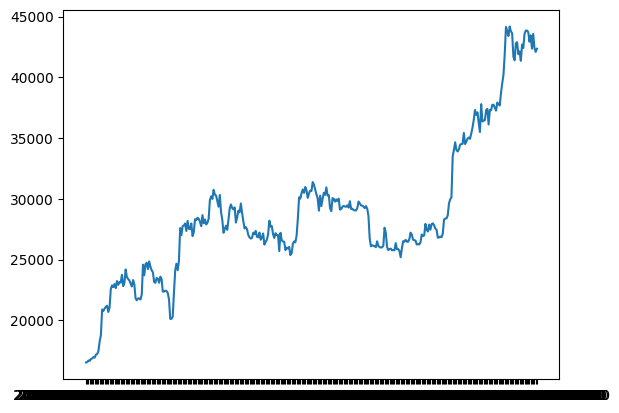

In [11]:
temp = y[y.ID.str.contains('00:00:00')]
plt.plot(temp.ID, temp.close)
plt.show()

-> valid를 11-12월 정도로 나눠서 새롭게 변동하는 값을 잘 예측할 수 있도록 학습 시켜보자.

-> 24년에는 더 치솟으니까 3을 잘 예측할 수 있는 모델을 만드는 것도 중요할 듯

### ACF plot

- 24시간 전까지 자기 상관 존재

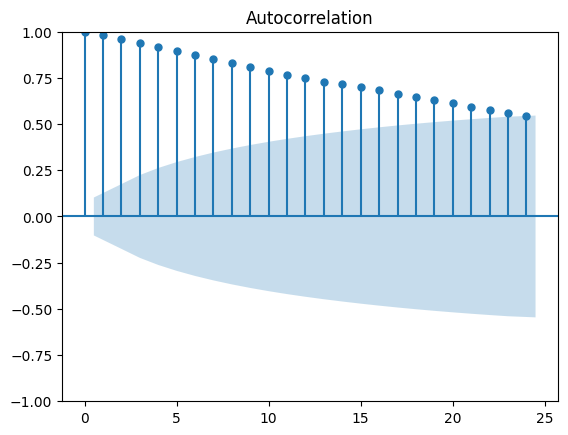

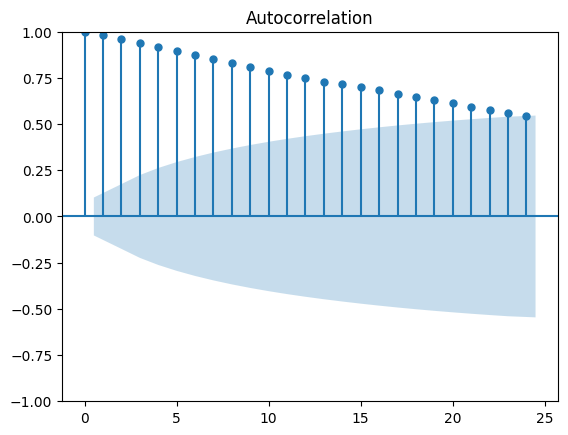

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(temp.close, lags=24)

- 데이터 목록

In [13]:
cols = df.columns.tolist()
data_list = ['_'.join(x.split('_')[:3]) for x in cols]
Counter(data_list)

Counter({'hourly_market-data_liquidations': 104,
         'hourly_market-data_taker-buy-sell-stats': 40,
         'hourly_market-data_open-interest': 28,
         'hourly_market-data_funding-rates': 8,
         'hourly_network-data_fees': 5,
         'hourly_network-data_fees-transaction': 4,
         'hourly_network-data_tokens-transferred': 3,
         'hourly_network-data_addresses-count': 3,
         'hourly_network-data_transactions-count': 2,
         'hourly_market-data_price-ohlcv': 2,
         'hourly_network-data_supply': 2,
         'hourly_network-data_blockreward': 2,
         'hourly_market-data_coinbase-premium-index': 2,
         'ID': 1,
         'target': 1,
         '_type': 1,
         'hourly_network-data_difficulty': 1,
         'hourly_network-data_utxo-count': 1,
         'hourly_network-data_hashrate': 1,
         'hourly_network-data_block-count': 1,
         'hourly_network-data_block-interval': 1,
         'hourly_network-data_block-bytes': 1,
         'hour

## 2. market-data liquidations 탐색

  | endpoint                 | description                                                                                     |
  | ------------------------ | ----------------------------------------------------------------------------------------------- |
  | LIQUIDATIONS             | 청산은 포지션의 손실이 손익 극단적으로 커져 포지션을 강제로 청산하는 것을 의미합니다.                                |
  |                          | **long liquidations(매수 포지션 청산)** : 한 트레이더가 비트코인 가격이 상승할 것으로 예상하고 100 BTC를 매수 포지션을 가지고 있습니다. 그러나 시장은 그 트레이더의 예상과는 반대로 가격이 급격히 하락하는 상황이 발생합니다. 이 경우, 가격 하락으로 인해 그 트레이더의 매수 포지션은 손실을 보게 됩니다. 손실이 손익 극단적으로 커져서 트레이더의 계정 자본이 설정된 한도 이하로 떨어지면, 거래소나 플랫폼은 해당 포지션을 강제로 청산합니다.                                                           |
  |                          | **short liquidations(공매도 포지션 청산)** : 만약 트레이더가 비트코인 가격이 하락할 것으로 예상하고 100 BTC를 공매도 포지션을 가지고 있다가 가격이 상승한다면, 그 포지션도 손실을 보게 됩니다. 손실이 손익 극단적으로 커져서 계정 자본이 한도 이하로 떨어지면, 거래소나 플랫폼은 해당 포지션을 강제로 청산할 것입니다.      | 


- exchanges : BINANCE, BITFINEX, BYBIT, DERIBIT, FTX_GLOBAL, HTX_GLOBAL, HUOBI_GLOBAL, OKEX, OKX, ALL_EXCHANGES
- symbol : SPOT_BTC_USD, SPOT_BTC_BUSD, SPOT_BTC_USDT, ALL_SYMBOL
- 지표 : VWAP (거래량 가중 평균 가격)

변수 종류
- short_liquidations
- long_liquidations
- short_liquidations_usd
- long_liquidations_usd

In [11]:
liquidation = df.loc[:,df.columns.str.contains('hourly_market-data_liquidations').tolist()]
liquidation = pd.concat([df[['ID','target']],liquidation], axis = 1)

### Correlation plot

- long-liquidation - usd 는 완전한 선형관계
- 거래소간의 상관관계가 엄청 높은 편
    - 이 중에서도 deribit, bitfinex이라는 거래소가 혼자 다른 양상
    -> 다른 거래소는 다 지우고 얘네랑 all_exchange_all_symbol만 살려도 될 듯  

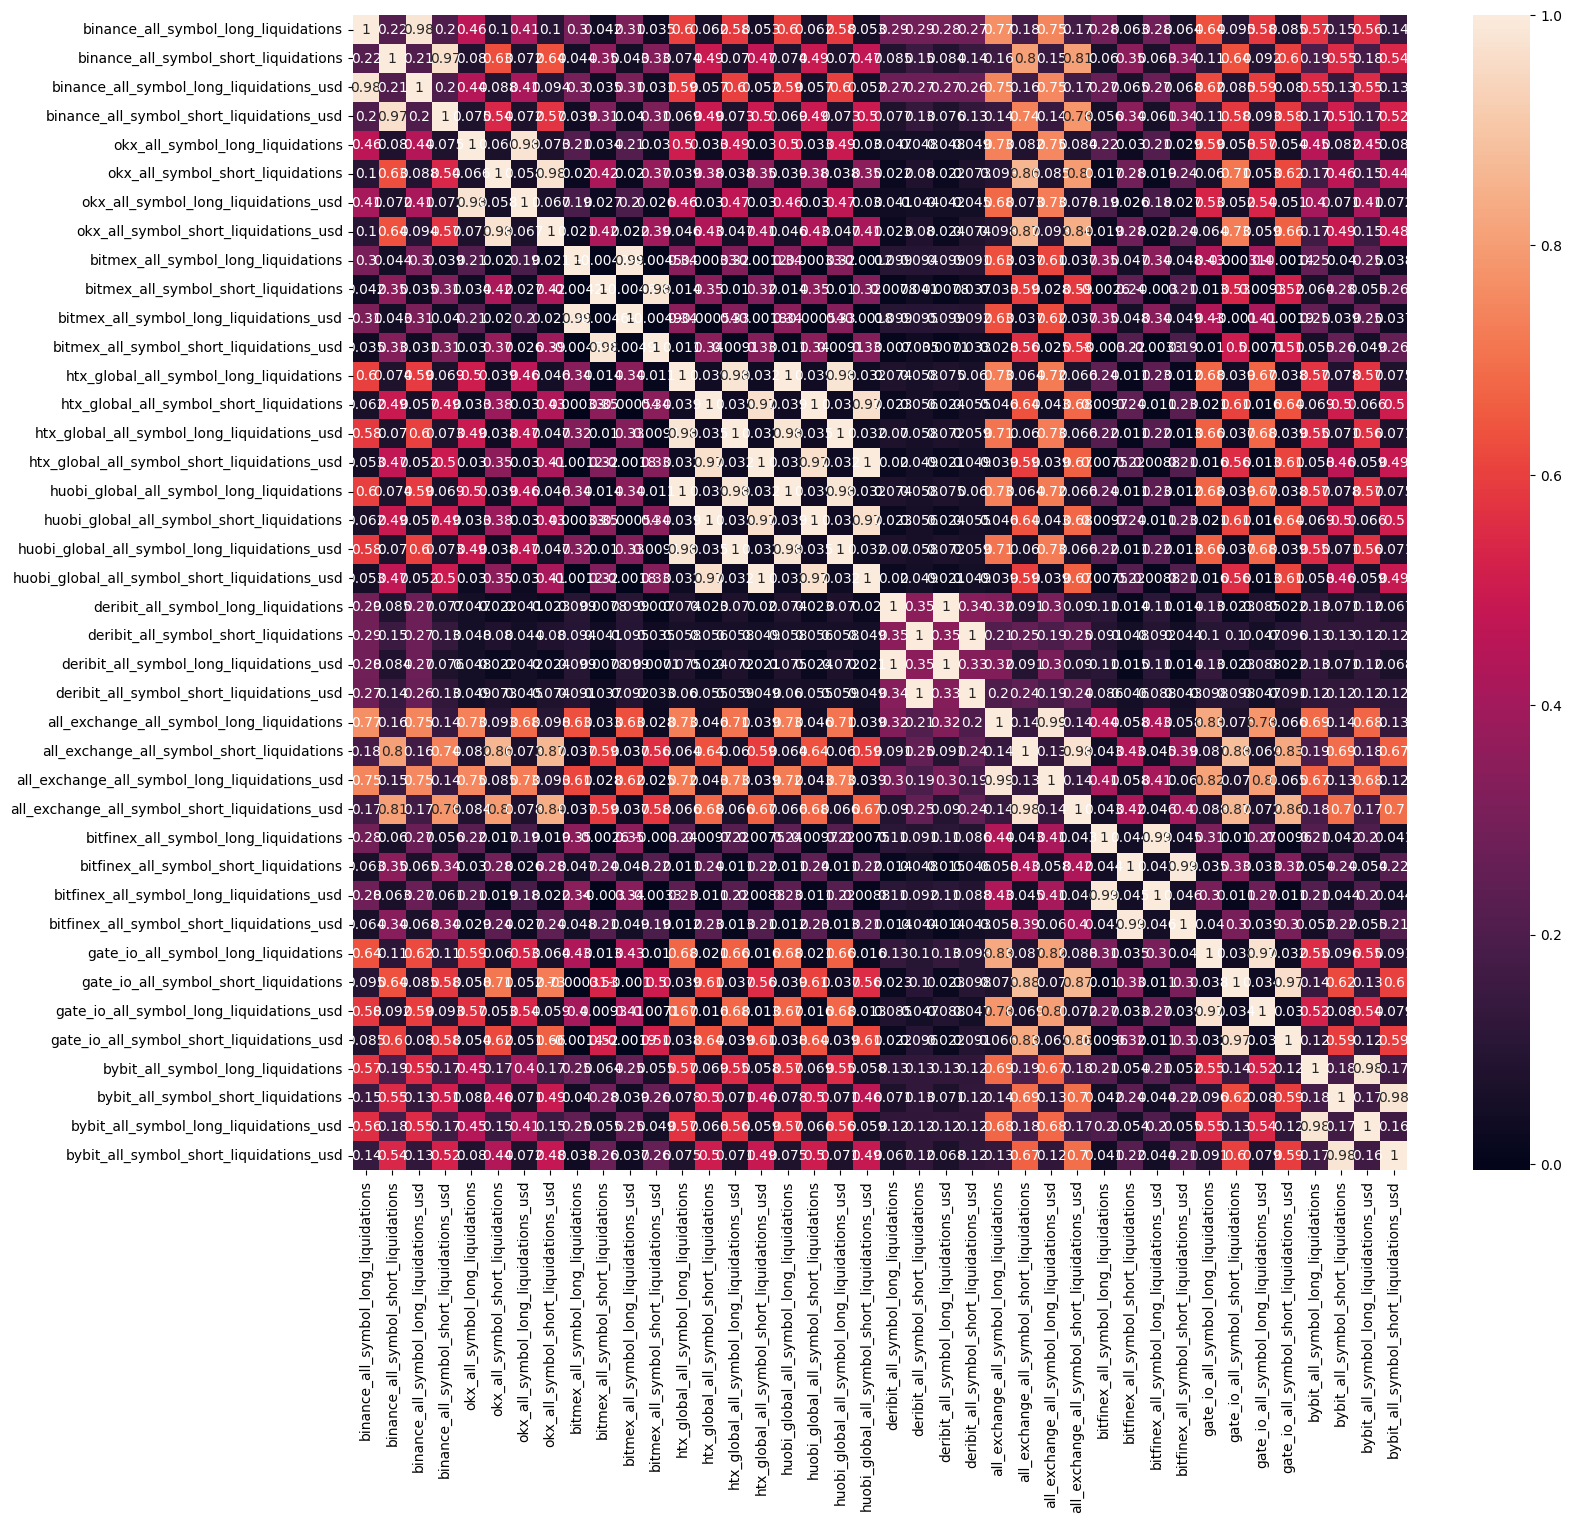

In [12]:
x = liquidation[liquidation.ID < '2024-01-01'].drop(columns = ['target', 'ID'])
x.columns = [c.replace("hourly_market-data_liquidations_", "") for c in x.columns]
x =x[x.columns[x.columns.str.contains('all_symbol')]]

corr_matrix = x.corr('pearson')

plt.figure(figsize = (17,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
liquidation2 = liquidation.melt(id_vars = ['ID','target'])

In [15]:
import re
exchanges_pattern = r"binance|bitfinex|bybit|deribit|ftx|htx_global|huobi_global|okex|okx|bitmex|gate_io|all_exchange"
symbol_pattern = r"btc_usdt|btc_usd|btc_busd|all_symbol"
col_pattern = r"long_liquidations_usd|short_liquidations_usd|long_liquidations|short_liquidations"

liquidation2['exchange'] = liquidation2['variable'].apply(lambda x : ''.join(re.findall(exchanges_pattern, x)))
liquidation2['symbol'] = liquidation2['variable'].apply(lambda x : ''.join(re.findall(symbol_pattern, x)))
liquidation2['col'] = liquidation2['variable'].apply(lambda x : ''.join(re.findall(col_pattern, x)))

In [16]:
liquidation2 = liquidation2.sort_values(by = 'ID')
liquidation2.drop(columns = 'variable', inplace = True)

In [17]:
liquidation2

ID  target  value    exchange      symbol  \
0        2023-01-01 00:00:00     2.0    0.0       bybit     btc_usd   
877952   2023-01-01 00:00:00     2.0    0.0  htx_global    btc_usdt   
866400   2023-01-01 00:00:00     2.0    0.0  htx_global     btc_usd   
854848   2023-01-01 00:00:00     2.0    0.0  htx_global     btc_usd   
843296   2023-01-01 00:00:00     2.0    0.0  htx_global     btc_usd   
...                      ...     ...    ...         ...         ...   
843295   2024-04-26 07:00:00     NaN    0.0  htx_global     btc_usd   
854847   2024-04-26 07:00:00     NaN    0.0  htx_global     btc_usd   
866399   2024-04-26 07:00:00     NaN    0.0  htx_global     btc_usd   
750879   2024-04-26 07:00:00     NaN    NaN    bitfinex  all_symbol   
1201407  2024-04-26 07:00:00     NaN    NaN     deribit     btc_usd   

                            col  
0             long_liquidations  
877952        long_liquidations  
866400   short_liquidations_usd  
854848    long_liquidations_usd  
843296       short_liquidations  
...                         ...  
843295        long_liquidations  
854847       short_liquidations  
866399    long_liquidations_usd  
750879        long_liquidations  
1201407  short_liquidations_usd  

[1201408 rows x 6 columns]

In [18]:
long = liquidation2[liquidation2.col == 'long_liquidations'].rename(columns = {'value' : 'long_liquidations'}).drop(columns = 'col').reset_index(drop=True)
short = liquidation2[liquidation2.col == 'short_liquidations'].rename(columns = {'value' : 'short_liquidations'}).drop(columns = 'col').reset_index(drop=True)
long_usd = liquidation2[liquidation2.col == 'long_liquidations_usd'].rename(columns = {'value' : 'long_liquidations_usd'}).drop(columns = 'col').reset_index(drop=True)
short_usd = liquidation2[liquidation2.col == 'short_liquidations_usd'].rename(columns = {'value' : 'short_liquidations_usd'}).drop(columns = 'col').reset_index(drop=True)

In [20]:
liquidation3 = pd.merge(long,short, how='outer')
liquidation3 = pd.merge(liquidation3, long_usd, how='outer')
liquidation3 = pd.merge(liquidation3, short_usd, how='outer')
liquidation3 = liquidation3[liquidation3.ID < '2024-01-01']
liquidation3

ID  target  long_liquidations      exchange  \
0       2023-01-01 00:00:00     2.0           0.012000  all_exchange   
1       2023-01-01 00:00:00     2.0           0.012000       binance   
2       2023-01-01 00:00:00     2.0           0.000000       binance   
3       2023-01-01 00:00:00     2.0           0.000000       binance   
4       2023-01-01 00:00:00     2.0           0.012000       binance   
...                     ...     ...                ...           ...   
227755  2023-12-31 23:00:00     2.0           0.000000  huobi_global   
227756  2023-12-31 23:00:00     2.0           0.224000  huobi_global   
227757  2023-12-31 23:00:00     2.0           0.402906           okx   
227758  2023-12-31 23:00:00     2.0           0.042906           okx   
227759  2023-12-31 23:00:00     2.0           0.360000           okx   

            symbol  short_liquidations  long_liquidations_usd  \
0       all_symbol               0.000               197.5161   
1       all_symbol               0.000               197.5161   
2         btc_busd               0.000                 0.0000   
3          btc_usd               0.000                 0.0000   
4         btc_usdt               0.000               197.5161   
...            ...                 ...                    ...   
227755     btc_usd               0.000                 0.0000   
227756    btc_usdt               0.016              9434.3652   
227757  all_symbol               0.010             16899.5100   
227758     btc_usd               0.000              1800.0000   
227759    btc_usdt               0.010             15099.5100   

        short_liquidations_usd  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0000  
4                       0.0000  
...                        ...  
227755                  0.0000  
227756                678.4432  
227757                422.1930  
227758                  0.0000  
227759                422.1930  

[227760 rows x 8 columns]

### Exchange 탐색

1. exchange별 long, short liquidation mean
    - bitmex가 long이 많은 듯

<Axes: xlabel='exchange', ylabel='count'>

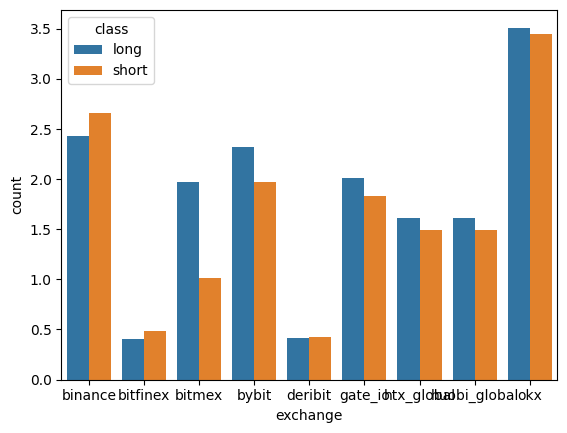

In [21]:
x1 = liquidation3.groupby('exchange')['long_liquidations'].mean().reset_index().rename(columns = {'long_liquidations' : 'count'})
x1=x1[x1.exchange != 'all_exchange']
x1['class'] = 'long'

x2 = liquidation3.groupby('exchange')['short_liquidations'].mean().reset_index().rename(columns = {'short_liquidations' : 'count'})
x2=x2[x2.exchange != 'all_exchange']
x2['class'] = 'short'

x = pd.concat([x1, x2])
x = x[~x.exchange.isin(['ftx', 'okex'])]

sns.barplot(x="exchange", y="count", data=x, hue='class')

2. target별 long liquidation mean
    - 전반적으로 all_exchange와 비슷한 양상

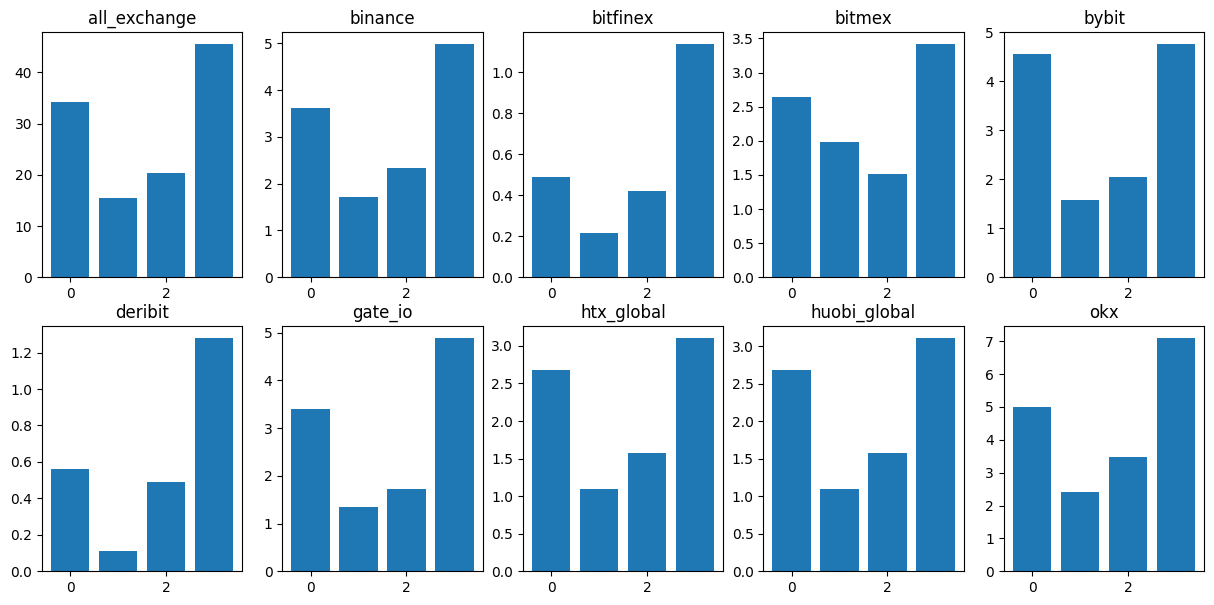

In [65]:
# long liquidations
exchange_lst = liquidation3.exchange.unique().tolist()

fig, axes = plt.subplots(2,5, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = liquidation3[liquidation3.exchange == exchange_lst[i]]
    x = x.groupby('target')['long_liquidations'].mean().reset_index()
    ax.bar(x='target', height = 'long_liquidations', data = x)
    ax.set_title(exchange_lst[i])

3. target별 short liquidation mean
    - 전반적으로 all_exchange와 비슷한 양상

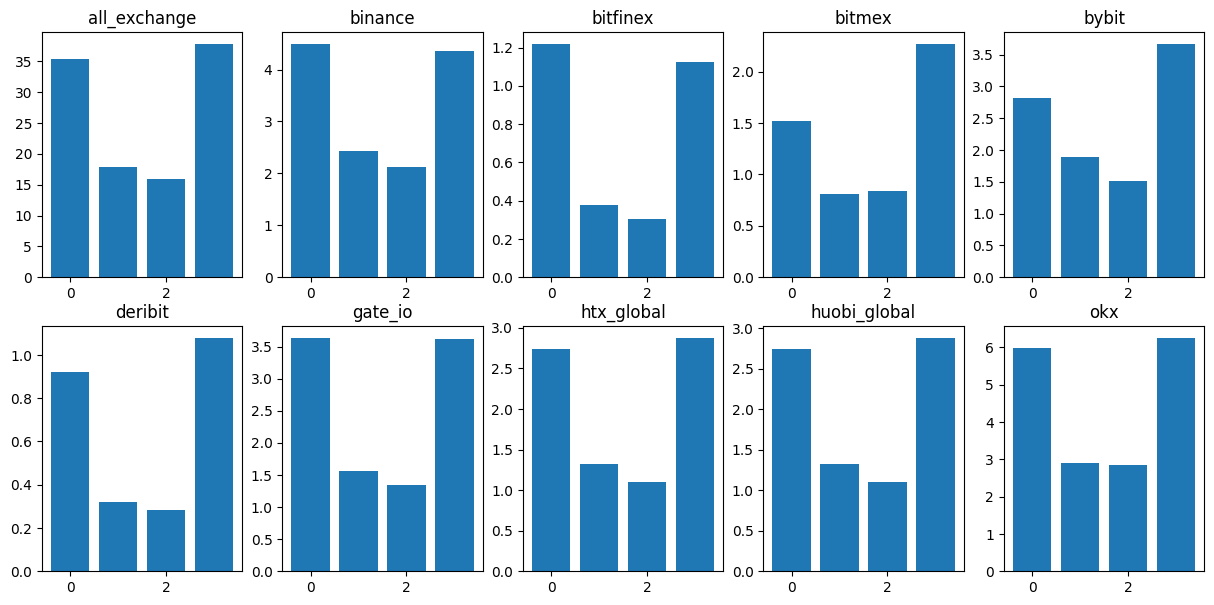

In [23]:
# short liquidations
exchange_lst = liquidation3.exchange.unique().tolist()

fig, axes = plt.subplots(2,5, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = liquidation3[liquidation3.exchange == exchange_lst[i]]
    x = x.groupby('target')['short_liquidations'].mean().reset_index()
    ax.bar(x='target', height = 'short_liquidations', data = x)
    ax.set_title(exchange_lst[i])

4. target별 liquidation diff mean
    - long liquidations - short liquidations
    - 오 bybit 혼자 다르다
    - 그런데 사실 예상했던 결과와는 달라서 이해는 안됨 (비트코인이 하락하면 롱 포지션 청산이 많아야 하는거 아닌가??)

    -> short 청산 값 자체가 훨씬 커서 mean 계산하면 음수가 되나?

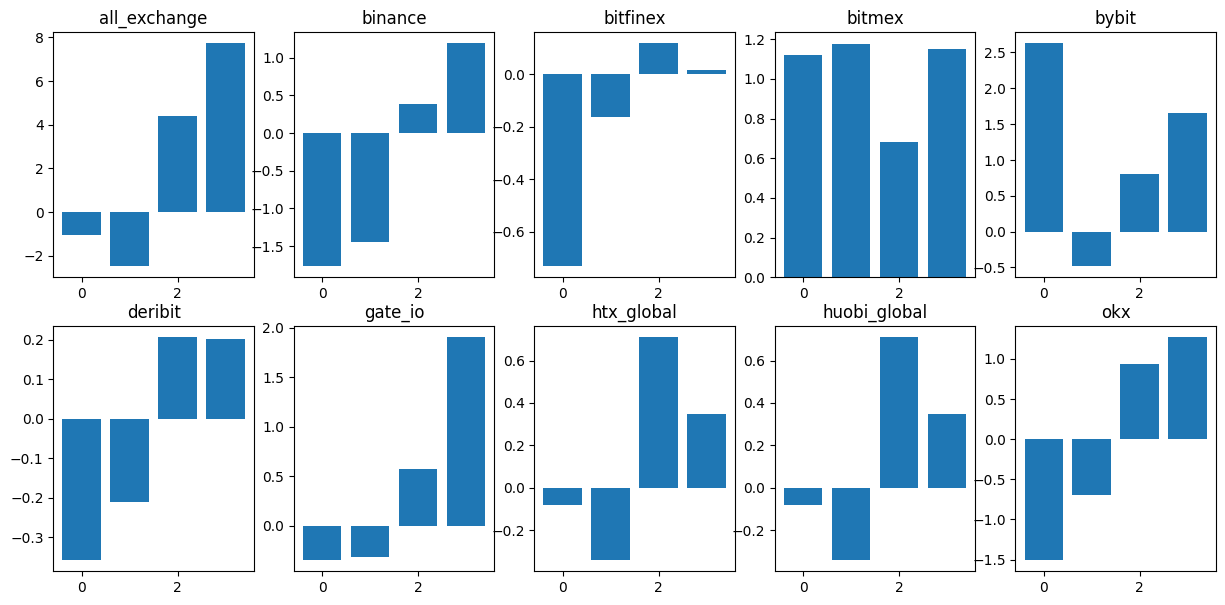

In [24]:
# long liquidations - short liquidations

exchange_lst = liquidation3.exchange.unique().tolist()

liquidation3['long_short_diff'] = liquidation3['long_liquidations'] - liquidation3['short_liquidations']
fig, axes = plt.subplots(2,5, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = liquidation3[(liquidation3.exchange == exchange_lst[i]) & (liquidation3.symbol == 'all_symbol')]
    x = x.groupby('target')['long_short_diff'].mean().reset_index()
    ax.bar(x='target', height = 'long_short_diff', data = x)
    ax.set_title(exchange_lst[i])

In [30]:
liquidation3['long_liquidations'].max()

2074.4117539500003

In [31]:
liquidation3['short_liquidations'].max()

3469.52039636

5. 청산 압력 지수 (Liquidation Pressure Index):
   - (롱 포지션 청산 - 숏 포지션 청산) / (롱 포지션 청산 + 숏 포지션 청산)
   - 청산의 방향성
      - 양수면 롱 포지션 청산이 우세
      - 음수면 숏 포지션 청산이 우세
   - 양,음 경향성만 보자면 all exchange에 추가로 binance, bitfinex 정도 살려보면 좋을 듯

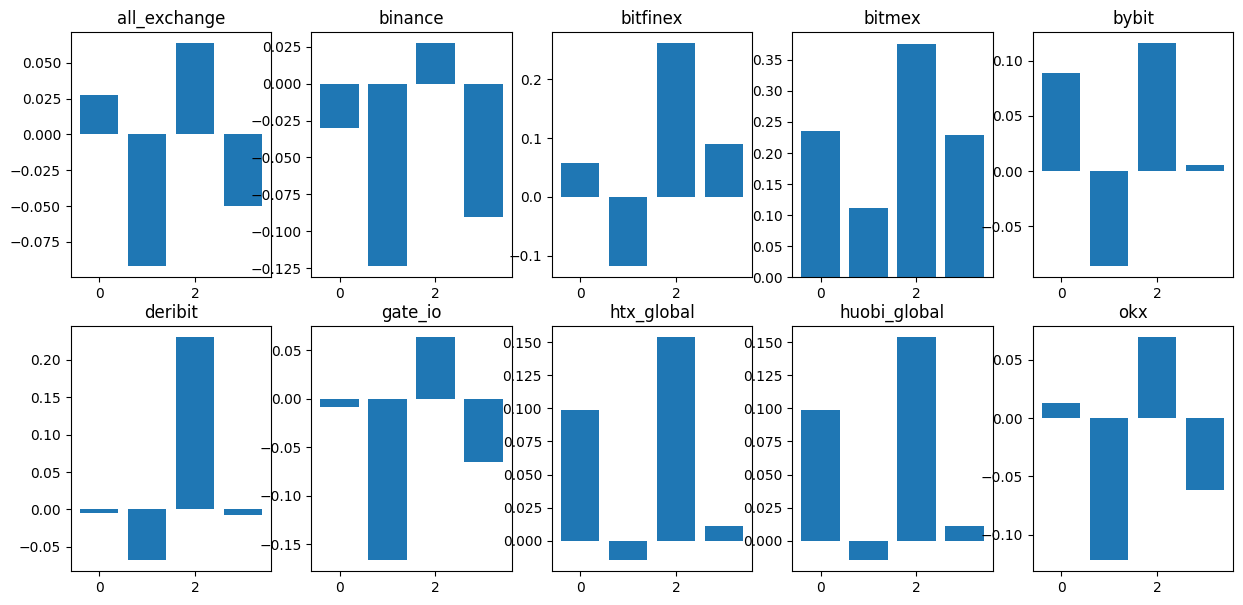

In [25]:
exchange_lst = liquidation3.exchange.unique().tolist()

liquidation3['liquidation_index'] = (liquidation3['long_liquidations'] - liquidation3['short_liquidations'])/(liquidation3['long_liquidations'] + liquidation3['short_liquidations'])
fig, axes = plt.subplots(2,5, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = liquidation3[(liquidation3.exchange == exchange_lst[i]) & (liquidation3.symbol == 'all_symbol')]
    x = x.groupby('target')['liquidation_index'].mean().reset_index()
    ax.bar(x='target', height = 'liquidation_index', data = x)
    ax.set_title(exchange_lst[i])

### symbol 탐색

- USD: 미국의 법정 화폐로, 중앙 은행의 통제를 받는 실제 화폐
- BUSD, USDT: 스테이블 코인으로, 달러 가치에 1:1로 연동된 암호화폐이지만, 발행사와 규제 차이가 있다.
  - BUSD: Paxos와 Binance에 의해 발행되고, 규제를 받는 스테이블 코인
  - USDT: Tether사가 발행하며, 사용이 가장 광범위하지만, 투명성 논란
  
-> all_exchange 로 정리한 변수가 없음

6. symbol별 long, short liquidation mean
    - btc_usdt가 가장 많은 듯

<Axes: xlabel='symbol', ylabel='count'>

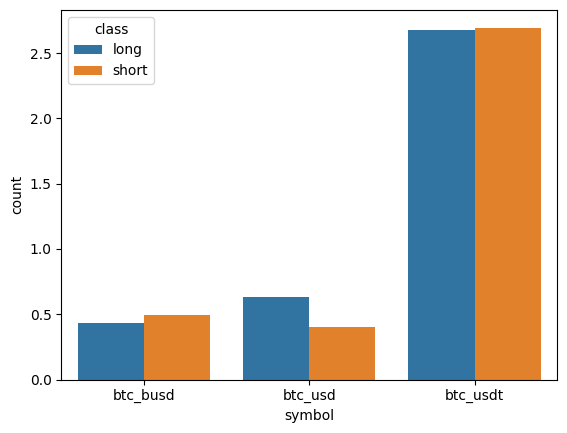

In [26]:
x1 = liquidation3.groupby('symbol')['long_liquidations'].mean().reset_index().rename(columns = {'long_liquidations' : 'count'})
x1=x1[x1.symbol != 'all_symbol']
x1['class'] = 'long'

x2 = liquidation3.groupby('symbol')['short_liquidations'].mean().reset_index().rename(columns = {'short_liquidations' : 'count'})
x2=x2[x2.symbol != 'all_symbol']
x2['class'] = 'short'

x = pd.concat([x1, x2])

sns.barplot(x="symbol", y="count", data=x, hue='class')

7. target별 long liquidation mean
    - all exchange과 대부분 비슷한 양상

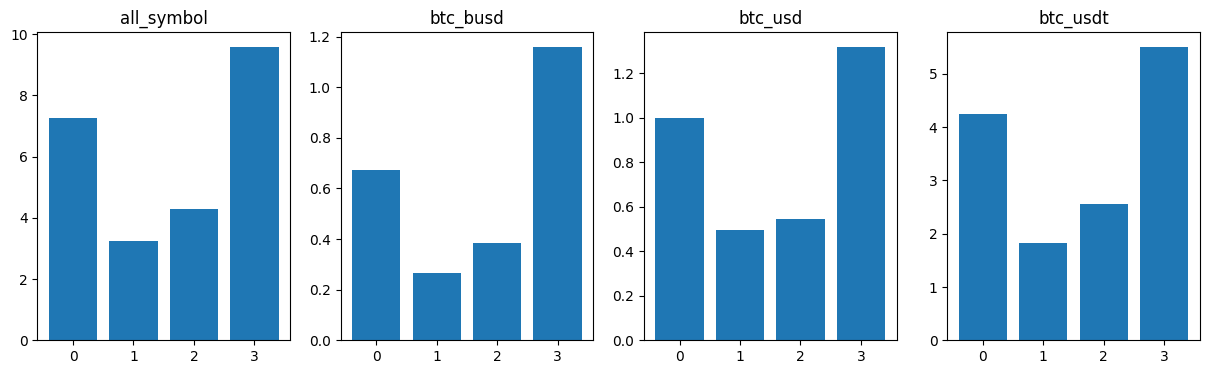

In [27]:
# long liquidations
symbol_lst = liquidation3.symbol.unique().tolist()

fig, axes = plt.subplots(1,4, figsize = (15,4))
for i, ax in enumerate(axes.flat):
    x = liquidation3[liquidation3.symbol == symbol_lst[i]]
    x = x.groupby('target')['long_liquidations'].mean().reset_index()
    ax.bar(x='target', height = 'long_liquidations', data = x)
    ax.set_title(symbol_lst[i])

8. target별 short liquidation mean
    - all exchange과 대부분 비슷한 양상

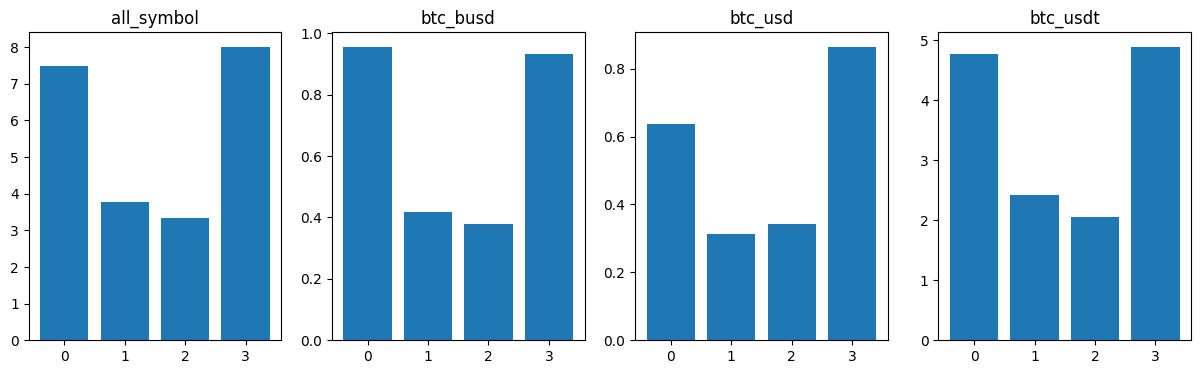

In [28]:
# short liquidations
symbol_lst = liquidation3.symbol.unique().tolist()

fig, axes = plt.subplots(1,4, figsize = (15,4))
for i, ax in enumerate(axes.flat):
    x = liquidation3[liquidation3.symbol == symbol_lst[i]]
    x = x.groupby('target')['short_liquidations'].mean().reset_index()
    ax.bar(x='target', height = 'short_liquidations', data = x)
    ax.set_title(symbol_lst[i])

9. target별 liquidation diff mean
    - long liquidations - short liquidations
    - btc_usd만 좀 다르긴 한데 유의미할지 잘 모르겠음..

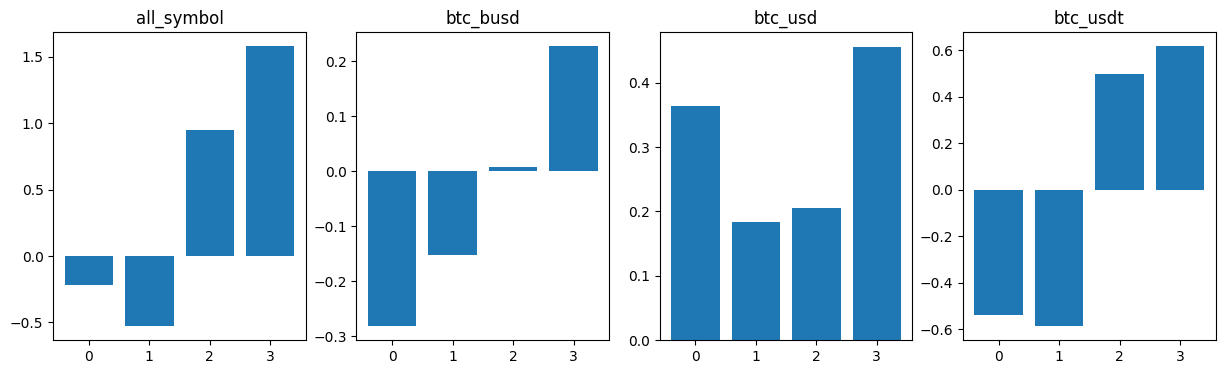

In [29]:
# long liquidations - short liquidations
symbol_lst = liquidation3.symbol.unique().tolist()

liquidation3['long_short_diff'] = liquidation3['long_liquidations'] - liquidation3['short_liquidations']
fig, axes = plt.subplots(1,4, figsize = (15,4))
for i, ax in enumerate(axes.flat):
    x = liquidation3[liquidation3.symbol == symbol_lst[i]]
    x = x.groupby('target')['long_short_diff'].mean().reset_index()
    ax.bar(x='target', height = 'long_short_diff', data = x)
    ax.set_title(symbol_lst[i])

### 결론
- all exchange all symbol 변수는 기본으로 사용 (usd 변수는 제거)
- 파생 변수
  - long short diff 
  - liquidation index 
- exchange 일부 추가
  - long_short diff : bybit
  - liquidation index : bitfinex, binance

## 3. taker-buy-sell-stats 탐색

 | endpoint                 | description                                                                                     |
  |--------------------------|-------------------------------------------------------------------------------------------------|
  | TAKER-BUY-SELL-STATS     | 시장에서 주체적으로 체결된 거래의 매수와 매도에 대한 통계                       |
  |                          | 블록체인에서 거래를 할 때에는 메이커가 호가창을 만들고 테이커가 시장가로 긁어서 비트코인을 매도/매수하게 된다. 예를 들어 taker buy volume은 테이커가 매수를 하는 양을 의미한다.                                          |

In [32]:
taker = df.loc[:,df.columns.str.contains('hourly_market-data_taker-buy-sell-stats').tolist()]
taker = pd.concat([df[['ID','target']],taker], axis = 1)
taker.head()

ID  target  \
0  2023-01-01 00:00:00     2.0   
1  2023-01-01 01:00:00     1.0   
2  2023-01-01 02:00:00     1.0   
3  2023-01-01 03:00:00     1.0   
4  2023-01-01 04:00:00     2.0   

   hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume  \
0                                           377290.0                  
1                                           463720.0                  
2                                           172790.0                  
3                                           176450.0                  
4                                           130040.0                  

   hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume  \
0                                           252550.0                   
1                                           116960.0                   
2                                           603920.0                   
3                                           199630.0                   
4                                           377920.0                   

   hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_ratio  \
0                                           0.599025                 
1                                           0.798581                 
2                                           0.222464                 
3                                           0.469182                 
4                                           0.256004                 

   hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_ratio  \
0                                           0.400975                  
1                                           0.201419                  
2                                           0.777536                  
3                                           0.530818                  
4                                           0.743996                  

   hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_sell_ratio  \
0                                           1.493922                      
1                                           3.964774                      
2                                           0.286114                      
3                                           0.883885                      
4                                           0.344094                      

   hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume  \
0                                          2015805.0                
1                                          4032601.0                
2                                           857595.0                
3                                          1237990.0                
4                                          2423293.0                

   hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume  \
0                                          1411658.0                 
1                                          1174054.0                 
2                                          1494750.0                 
3                                           869405.0                 
4                                          2816626.0                 

   hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio  ...  \
0                                           0.588133              ...   
1                                           0.774509              ...   
2                                           0.364570              ...   
3                                           0.587450              ...   
4                                           0.462468              ...   

   hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume  \
0                                       4.648309e+07                       
1                                       3.975599e+07                       
2                                       2.405402e+07                       
3                                       2.860215e+07                       
4

### Correlation plot

- buy_ratio + sell_ratio = 1 인듯 -> 둘 중 하나만 남기자
- all_exchange 기준으로 봤을 때 모든 거래소에서 buy, sell volume의 상관성이 엄청 높다. -> all_exchange로 퉁쳐도 되지 않을까
- binance의 비율이 높아서 all_exchange랑 상관성이 제일 높음

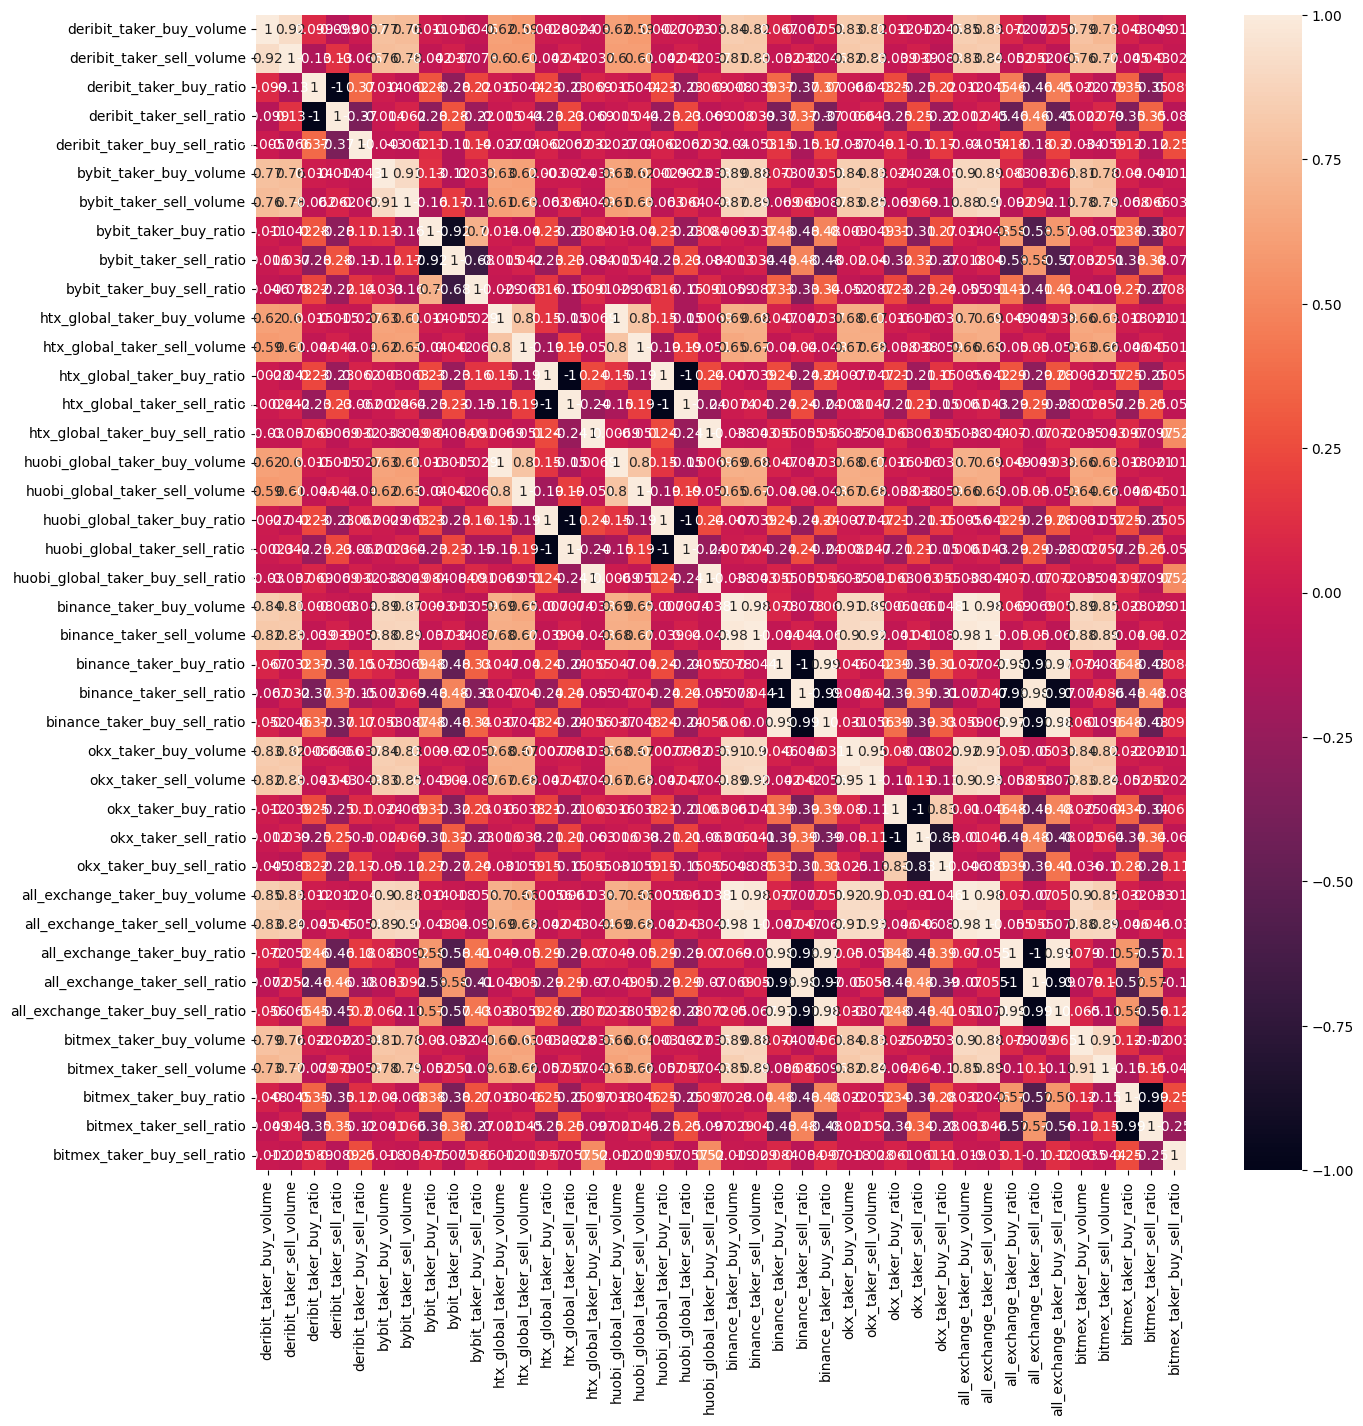

In [33]:
x = taker[taker.ID < '2024-01-01'].drop(columns = ['target', 'ID'])
x.columns = [c.replace("hourly_market-data_taker-buy-sell-stats_", "") for c in x.columns]

corr_matrix = x.corr('pearson')

plt.figure(figsize = (15,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [34]:
taker2 = taker.melt(id_vars = ['ID','target'])

In [35]:
import re
exchanges_pattern = r"binance|bitfinex|bybit|deribit|ftx|htx_global|huobi_global|okex|okx|bitmex|gate_io|all_exchange"
col_pattern = r"taker_buy_volume|taker_sell_volume|taker_buy_ratio|taker_sell_ratio|taker_buy_sell_ratio"

taker2['exchange'] = taker2['variable'].apply(lambda x : ''.join(re.findall(exchanges_pattern, x)))
taker2['col'] = taker2['variable'].apply(lambda x : ''.join(re.findall(col_pattern, x)))

In [36]:
taker2.head()

ID  target  \
0  2023-01-01 00:00:00     2.0   
1  2023-01-01 01:00:00     1.0   
2  2023-01-01 02:00:00     1.0   
3  2023-01-01 03:00:00     1.0   
4  2023-01-01 04:00:00     2.0   

                                            variable     value exchange  \
0  hourly_market-data_taker-buy-sell-stats_deribi...  377290.0  deribit   
1  hourly_market-data_taker-buy-sell-stats_deribi...  463720.0  deribit   
2  hourly_market-data_taker-buy-sell-stats_deribi...  172790.0  deribit   
3  hourly_market-data_taker-buy-sell-stats_deribi...  176450.0  deribit   
4  hourly_market-data_taker-buy-sell-stats_deribi...  130040.0  deribit   

                col  
0  taker_buy_volume  
1  taker_buy_volume  
2  taker_buy_volume  
3  taker_buy_volume  
4  taker_buy_volume

In [37]:
taker2 = taker2.sort_values(by = 'ID')
taker2.drop(columns = 'variable', inplace = True)

b_volume = taker2[taker2.col == 'taker_buy_volume'].rename(columns = {'value' : 'taker_buy_volume'}).drop(columns = 'col').reset_index(drop=True)
s_volume = taker2[taker2.col == 'taker_sell_volume'].rename(columns = {'value' : 'taker_sell_volume'}).drop(columns = 'col').reset_index(drop=True)
b_ratio = taker2[taker2.col == 'taker_buy_ratio'].rename(columns = {'value' : 'taker_buy_ratio'}).drop(columns = 'col').reset_index(drop=True)
s_ratio = taker2[taker2.col == 'taker_sell_ratio'].rename(columns = {'value' : 'taker_sell_ratio'}).drop(columns = 'col').reset_index(drop=True)
bs_raio = taker2[taker2.col == 'taker_buy_sell_ratio'].rename(columns = {'value' : 'taker_buy_sell_ratio'}).drop(columns = 'col').reset_index(drop=True)

taker3 = pd.merge(b_volume,s_volume, how='outer')
taker3 = pd.merge(taker3, b_ratio, how='outer')
taker3 = pd.merge(taker3, s_ratio, how='outer')
taker3 = pd.merge(taker3, bs_raio, how='outer')
taker3 = taker3[taker3.ID < '2024-01-01']
taker3

ID  target  taker_buy_volume      exchange  \
0      2023-01-01 00:00:00     2.0      4.648309e+07  all_exchange   
1      2023-01-01 00:00:00     2.0      4.151979e+07       binance   
2      2023-01-01 00:00:00     2.0      1.388700e+06        bitmex   
3      2023-01-01 00:00:00     2.0      2.015805e+06         bybit   
4      2023-01-01 00:00:00     2.0      3.772900e+05       deribit   
...                    ...     ...               ...           ...   
70075  2023-12-31 23:00:00     2.0      9.661518e+06         bybit   
70076  2023-12-31 23:00:00     2.0      5.898990e+06       deribit   
70077  2023-12-31 23:00:00     2.0      5.624000e+05    htx_global   
70078  2023-12-31 23:00:00     2.0      5.624000e+05  huobi_global   
70079  2023-12-31 23:00:00     2.0      1.436500e+07           okx   

       taker_sell_volume  taker_buy_ratio  taker_sell_ratio  \
0           5.137537e+07         0.475003          0.524997   
1           4.646436e+07         0.471901          0.528099   
2           1.533800e+06         0.475175          0.524825   
3           1.411658e+06         0.588133          0.411867   
4           2.525500e+05         0.599025          0.400975   
...                  ...              ...               ...   
70075       1.011208e+07         0.488607          0.511393   
70076       8.555620e+06         0.408104          0.591896   
70077       9.704000e+05         0.366910          0.633090   
70078       9.704000e+05         0.366910          0.633090   
70079       1.565300e+07         0.478546          0.521454   

       taker_buy_sell_ratio  
0                  0.904774  
1                  0.893584  
2                  0.905398  
3                  1.427970  
4                  1.493922  
...                     ...  
70075              0.955444  
70076              0.689487  
70077              0.579555  
70078              0.579555  
70079              0.917715  

[70080 rows x 8 columns]

In [38]:
taker3.exchange.unique()

array(['all_exchange', 'binance', 'bitmex', 'bybit', 'deribit',
       'htx_global', 'huobi_global', 'okx'], dtype=object)

1. exchange별 buy volume mean
    - binance 가 압도적

<Axes: xlabel='exchange', ylabel='count'>

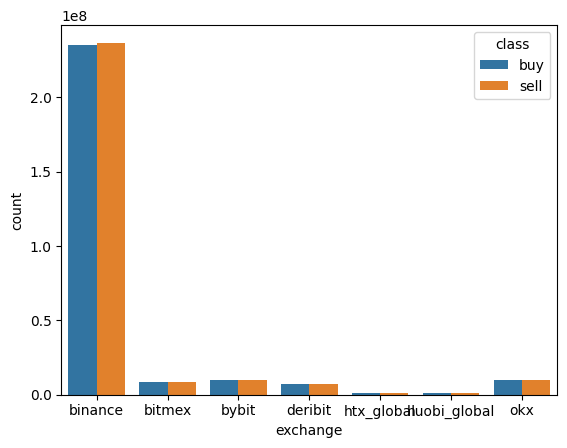

In [39]:
x1 = taker3.groupby('exchange')['taker_buy_volume'].mean().reset_index().rename(columns = {'taker_buy_volume' : 'count'})
x1=x1[x1.exchange != 'all_exchange']
x1['class'] = 'buy'

x2 = taker3.groupby('exchange')['taker_sell_volume'].mean().reset_index().rename(columns = {'taker_sell_volume' : 'count'})
x2=x2[x2.exchange != 'all_exchange']
x2['class'] = 'sell'

x = pd.concat([x1, x2])

sns.barplot(x="exchange", y="count", data=x, hue='class')

2. target별 buy volume mean
    - all exchange와 거의 비슷한 양상 -> all exchange만 살리기

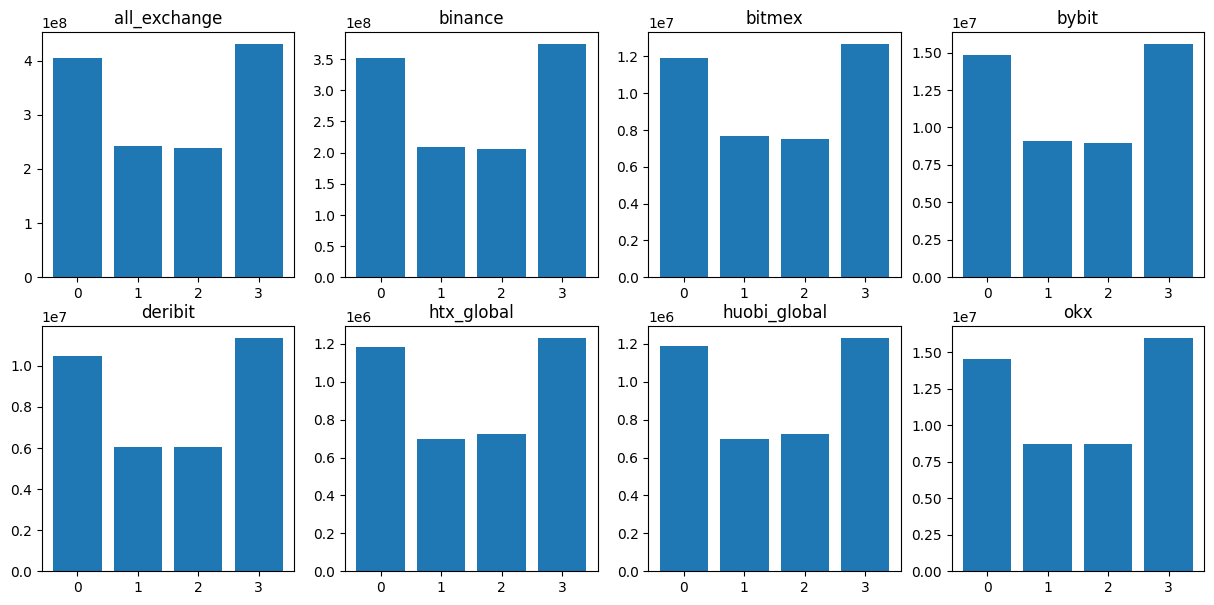

In [40]:
# taker buy volume
exchange_lst = taker3.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['taker_buy_volume'].mean().reset_index()
    ax.bar(x='target', height = 'taker_buy_volume', data = x)
    ax.set_title(exchange_lst[i])

3. target별 sell volume mean
    - all exchange와 거의 비슷한 양상 -> all exchange만 살리기

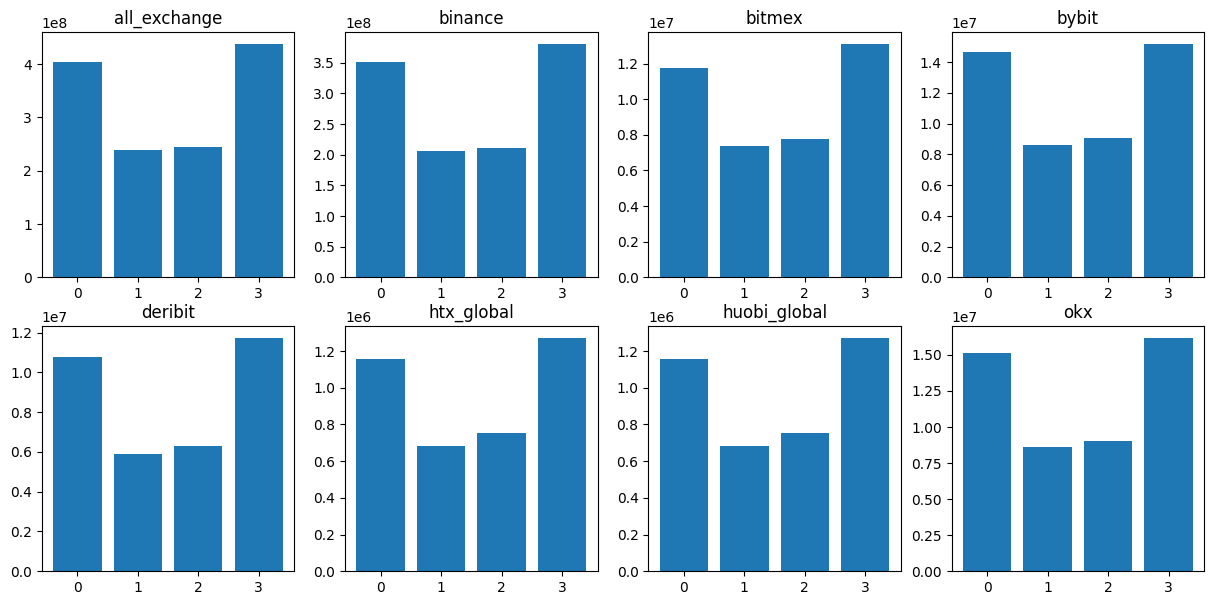

In [41]:
# taker sell volume
exchange_lst = taker3.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['taker_sell_volume'].mean().reset_index()
    ax.bar(x='target', height = 'taker_sell_volume', data = x)
    ax.set_title(exchange_lst[i])

4. target별 buy ratio mean
    - target별로 큰 차이는 안보임

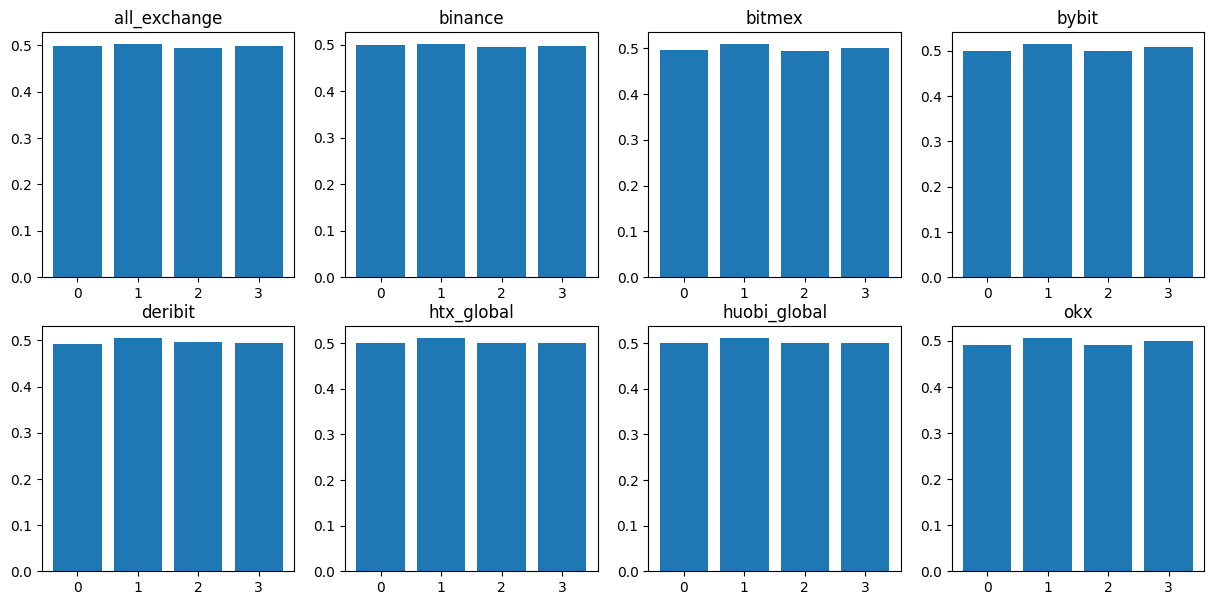

In [84]:
exchange_lst = taker3.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['taker_buy_ratio'].mean().reset_index()
    ax.bar(x='target', height = 'taker_buy_ratio', data = x)
    ax.set_title(exchange_lst[i])

5. target별 sell ratio mean
    - target별로 큰 차이 없음

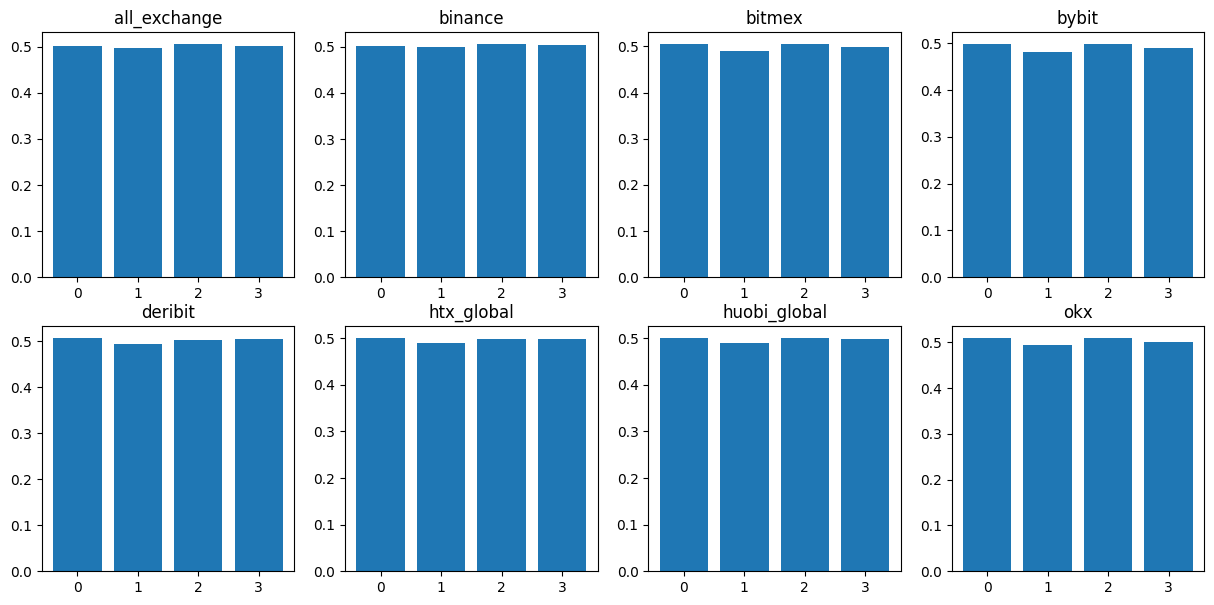

In [85]:
exchange_lst = taker3.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['taker_sell_ratio'].mean().reset_index()
    ax.bar(x='target', height = 'taker_sell_ratio', data = x)
    ax.set_title(exchange_lst[i])

6. target별 buy sell ratio mean
    - huobi_global (= htx_global)이 좀더 경향성이 두드러지는 편

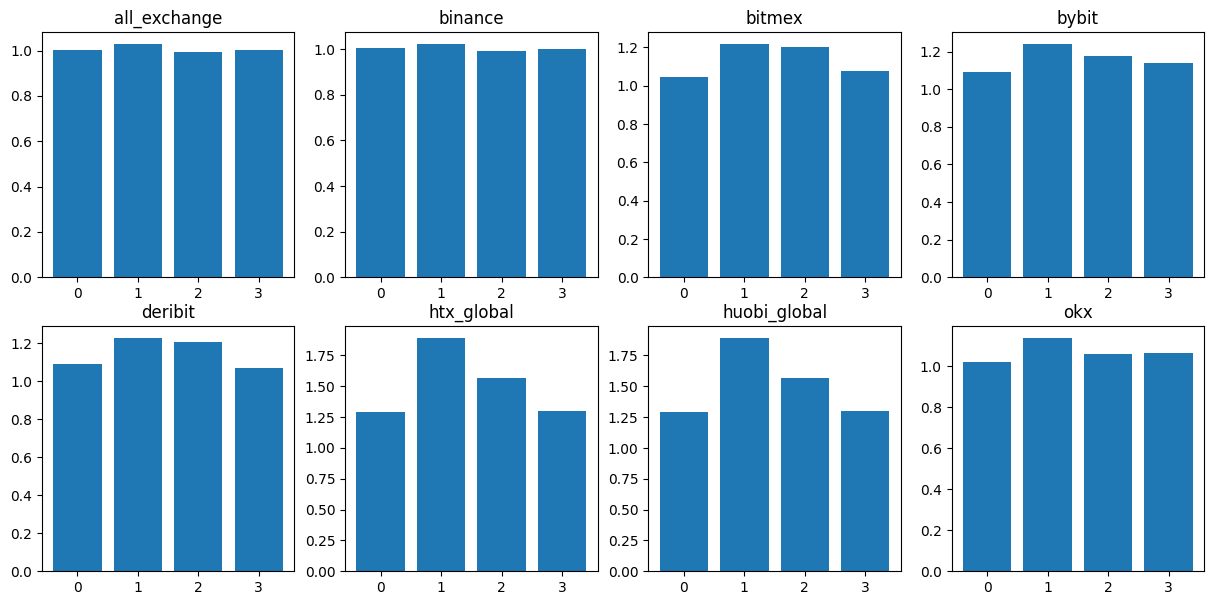

In [86]:
exchange_lst = taker3.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['taker_buy_sell_ratio'].mean().reset_index()
    ax.bar(x='target', height = 'taker_buy_sell_ratio', data = x)
    ax.set_title(exchange_lst[i])

7. target별 volume diff mean
    - buy volume - sell volume
    - 대부분 all exchange와 비슷한 경향
    - beribit, bybit, okx 정도가 좀 다른 듯

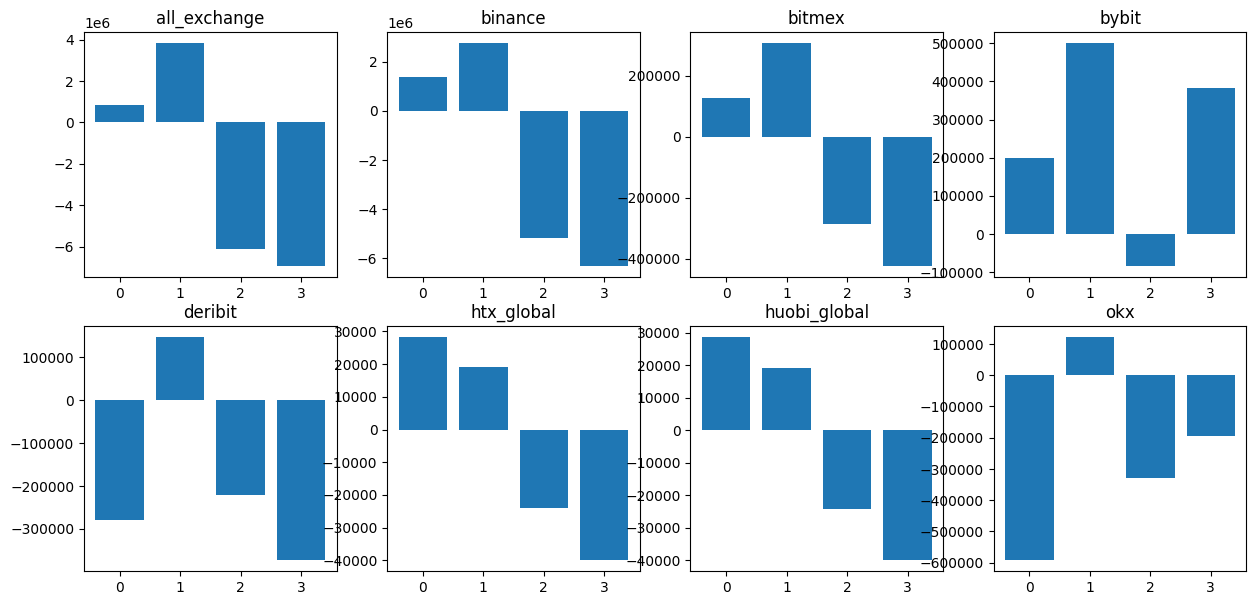

In [87]:
exchange_lst = taker3.exchange.unique().tolist()

taker3['volume_diff'] = taker3['taker_buy_volume'] - taker3['taker_sell_volume']
fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['volume_diff'].mean().reset_index()
    ax.bar(x='target', height = 'volume_diff', data = x)
    ax.set_title(exchange_lst[i])

8. volume index:
   - (taker-buy - taker-sell) / (taker-buy + taker-sell)
   - -1에서 1 사이의 값
      - 양수면 매수 우세 
      - 음수면 매도 우세
   - 뭐를 살리면 좋을지 애매.. 일단 all exchange만?

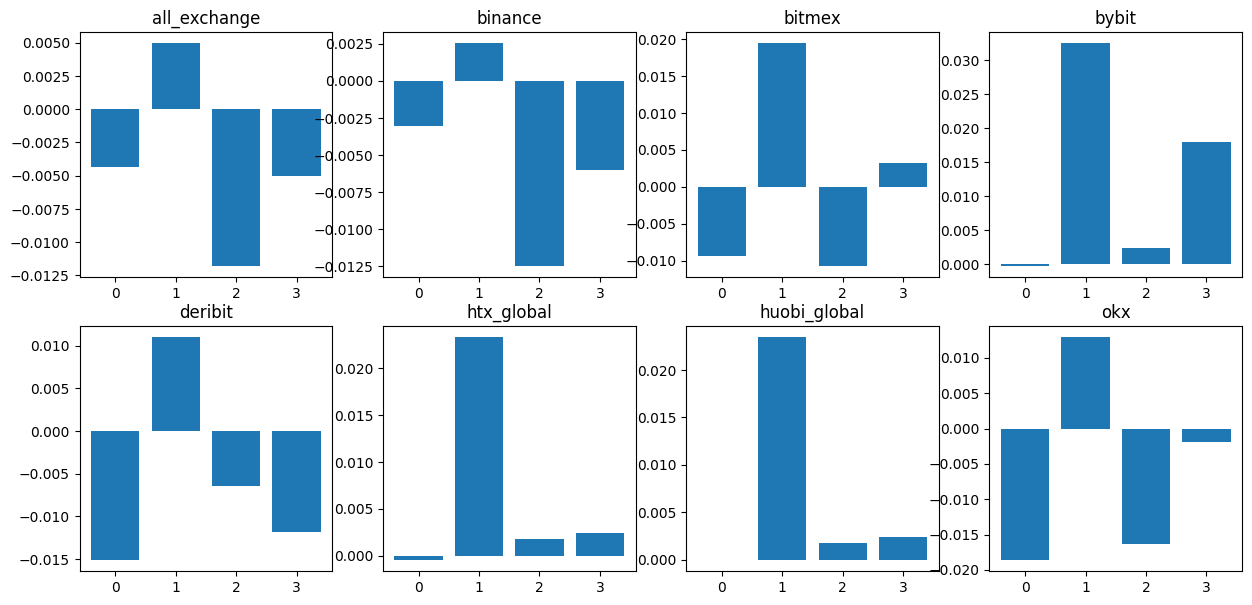

In [88]:
exchange_lst = taker3.exchange.unique().tolist()

taker3['volume_index'] = (taker3['taker_buy_volume'] - taker3['taker_sell_volume'])/(taker3['taker_buy_volume'] + taker3['taker_sell_volume'])
fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['volume_index'].mean().reset_index()
    ax.bar(x='target', height = 'volume_index', data = x)
    ax.set_title(exchange_lst[i])

- 0 : 대폭 하락 구간 -> 매도 우세
- 1 : 살짝 하락 구간 -> 대부분 매수 (이때다 싶어서..?)
- 2 : 살짝 상승 구간 -> 대부분 매도 (더 안오를 것 같아서..? 손절??)
- 3 : 대폭 상승 구간 -> 매수, 매도 다 있다. (비트코인 급상승에 대한 기대가 있는 걸까)

- global 거래소에서는 1일 때 제일 매수를 많이 하는듯??

9. target별 volume div mean
    - buy volume / sell volume
    - deribit, htx_global, huobi_global은 왤케 범위가 크지? sell volume이 너무 큰건가?
        - 이상치 포함 (혼자 너무 커서 mean 값이 튀어버림) 
        -> median 써보자.

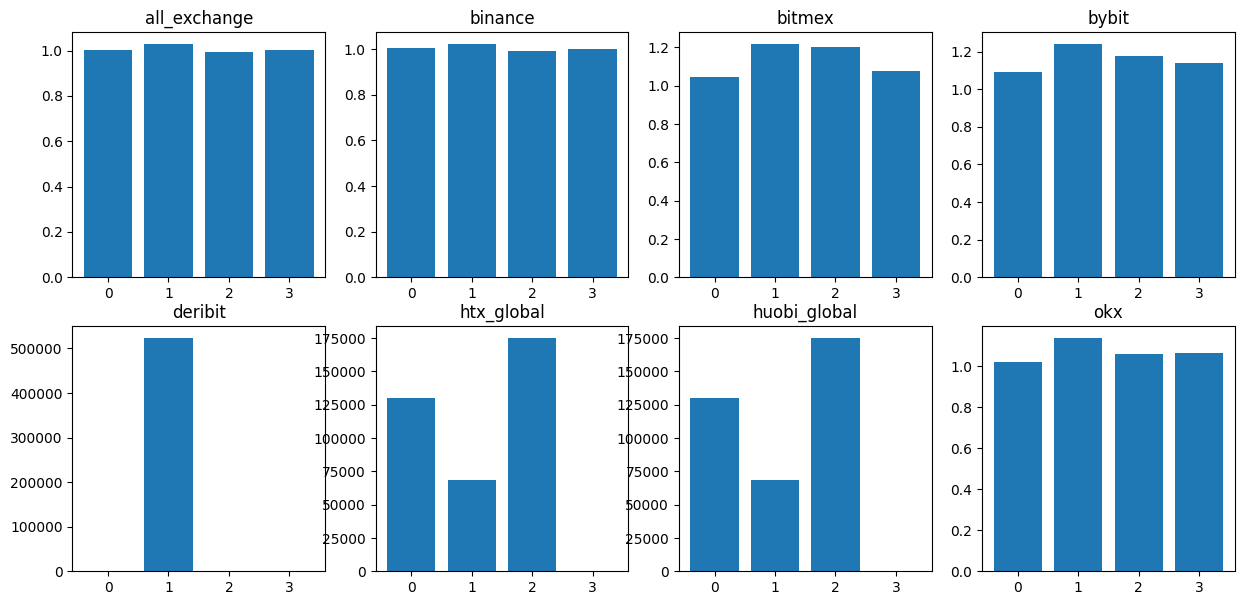

In [62]:
exchange_lst = taker3.exchange.unique().tolist()

taker3['volume_div'] = taker3['taker_buy_volume'] / (taker3['taker_sell_volume']+ 0.001)
fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['volume_div'].mean().reset_index()
    ax.bar(x='target', height = 'volume_div', data = x)
    ax.set_title(exchange_lst[i])

In [67]:
# 마지막 값만 혼자 e+09
taker3[(taker3.exchange == 'deribit') & (taker3.target == 1)]['volume_div'].sort_values()

1164     9.307880e-02
61652    1.001334e-01
42908    1.057793e-01
39092    1.273797e-01
62292    1.372683e-01
             ...     
48244    6.222366e+01
55148    9.834994e+01
2116     1.854000e+09
2076              NaN
2092              NaN
Name: volume_div, Length: 3544, dtype: float64

10. target별 volume div median
    - buy volume / sell volume
    - target별로 별 차이 없어 보임 -> 제거

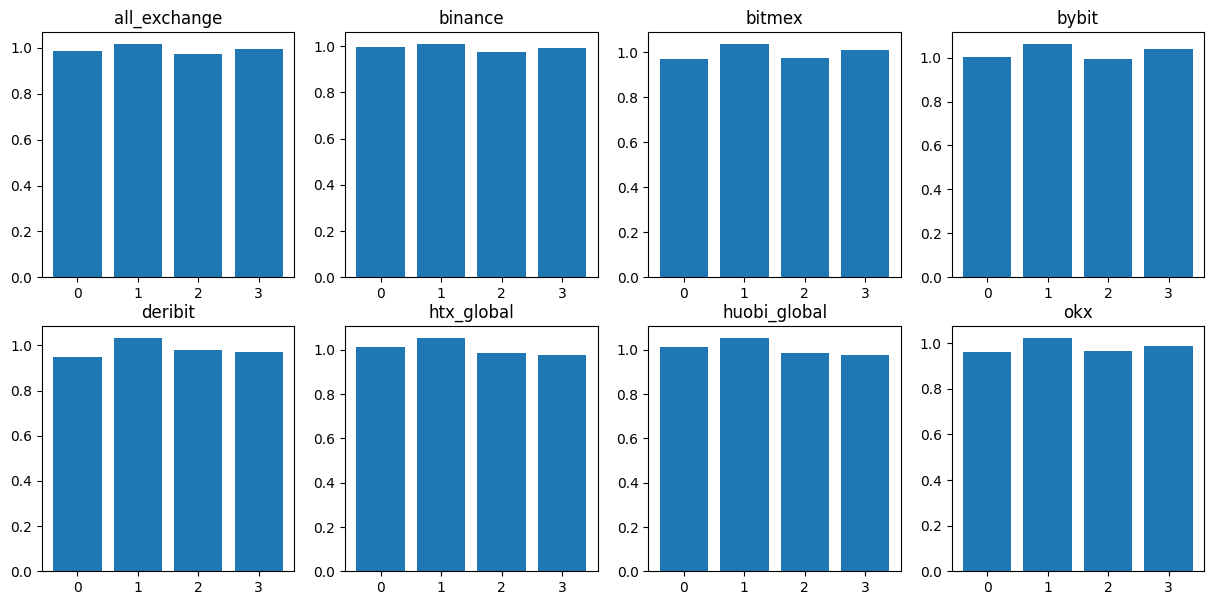

In [63]:
exchange_lst = taker3.exchange.unique().tolist()

taker3['volume_div'] = taker3['taker_buy_volume'] / (taker3['taker_sell_volume']+ 0.001)
fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = taker3[taker3.exchange == exchange_lst[i]]
    x = x.groupby('target')['volume_div'].median().reset_index()
    ax.bar(x='target', height = 'volume_div', data = x)
    ax.set_title(exchange_lst[i])

### 결론
- all exchange 변수는 기본으로 사용
- 파생 변수
  - volume diff
  - volume index 
- exchange 일부 추가
  - volume diff : deribit, bybit, okx
  - buy sell ratio : huobi global

## 4. open-interest 탐색

 | endpoint                 | description                                                                                     |
  |--------------------------|-------------------------------------------------------------------------------------------------|
  | OPEN-INTEREST            | 미결제 약정은 시장에 존재하는 미청산 계약의 총액을 나타내며, 이는 시장의 활동 수준을 파악하는 데 사용됩니다.              |
  |                          | 쉽게 “사람들이 얼마만큼 레버리지를 거는지”라고 생각하면 됩니다. 레버리지를 많이 쓸수록 증가합니다.                      |

In [45]:
interest = df.loc[:,df.columns.str.contains('hourly_market-data_open-interest').tolist()]
interest = pd.concat([df[['ID','target', col]],interest], axis = 1)

interest2 = interest.drop(columns = col).melt(id_vars = ['ID','target'])
interest2

ID  target  \
0       2023-01-01 00:00:00     2.0   
1       2023-01-01 01:00:00     1.0   
2       2023-01-01 02:00:00     1.0   
3       2023-01-01 03:00:00     1.0   
4       2023-01-01 04:00:00     2.0   
...                     ...     ...   
323451  2024-04-26 03:00:00     NaN   
323452  2024-04-26 04:00:00     NaN   
323453  2024-04-26 05:00:00     NaN   
323454  2024-04-26 06:00:00     NaN   
323455  2024-04-26 07:00:00     NaN   

                                                 variable         value  
0       hourly_market-data_open-interest_htx_global_bt...  3.412540e+07  
1       hourly_market-data_open-interest_htx_global_bt...  3.456750e+07  
2       hourly_market-data_open-interest_htx_global_bt...  3.452090e+07  
3       hourly_market-data_open-interest_htx_global_bt...  3.438940e+07  
4       hourly_market-data_open-interest_htx_global_bt...  3.439200e+07  
...                                                   ...           ...  
323451  hourly_market-data_open-interest_deribit_all_s...  8.659274e+08  
323452  hourly_market-data_open-interest_deribit_all_s...  8.693938e+08  
323453  hourly_market-data_open-interest_deribit_all_s...  8.714831e+08  
323454  hourly_market-data_open-interest_deribit_all_s...  8.610345e+08  
323455  hourly_market-data_open-interest_deribit_all_s...           NaN  

[323456 rows x 4 columns]

### Correlation plot

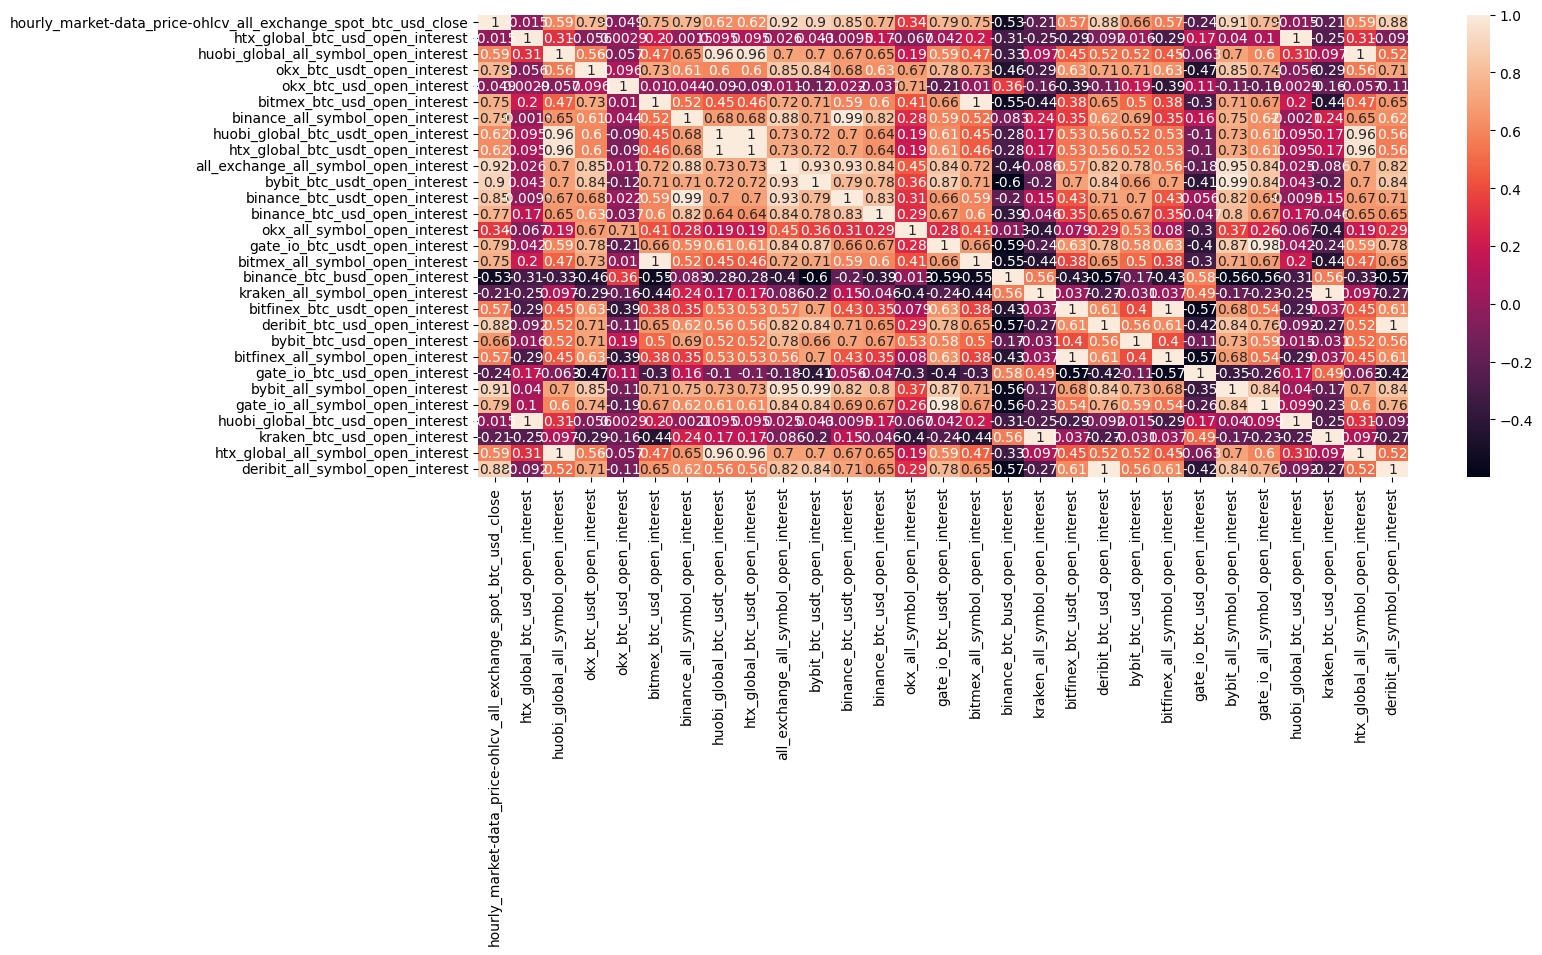

In [46]:
x = interest[interest.ID < '2024-01-01'].drop(columns = ['target', 'ID'])
x.columns = [c.replace("hourly_market-data_open-interest_", "") for c in x.columns]

corr_matrix = x.corr('spearman')

plt.figure(figsize = (15,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [47]:
import re
exchanges_pattern = r"binance|bitfinex|bybit|deribit|ftx|htx_global|huobi_global|okex|okx|bitmex|gate_io|kraken|all_exchange"
symbol_pattern = r"btc_usdt|btc_usd|btc_busd|all_symbol"

interest2['exchange'] = interest2['variable'].apply(lambda x : ''.join(re.findall(exchanges_pattern, x)))
interest2['symbol'] = interest2['variable'].apply(lambda x : ''.join(re.findall(symbol_pattern, x)))

interest2 = interest2.sort_values(by = 'ID')
interest2.drop(columns = 'variable', inplace = True)
interest2

ID  target         value      exchange      symbol
0       2023-01-01 00:00:00     2.0  3.412540e+07    htx_global     btc_usd
277248  2023-01-01 00:00:00     2.0  3.412540e+07  huobi_global     btc_usd
265696  2023-01-01 00:00:00     2.0  2.839404e+08       gate_io  all_symbol
254144  2023-01-01 00:00:00     2.0  1.568603e+09         bybit  all_symbol
242592  2023-01-01 00:00:00     2.0  2.146132e+07       gate_io     btc_usd
...                     ...     ...           ...           ...         ...
265695  2024-04-26 07:00:00     NaN  4.478387e+09         bybit  all_symbol
277247  2024-04-26 07:00:00     NaN           NaN       gate_io  all_symbol
288799  2024-04-26 07:00:00     NaN  4.291950e+07  huobi_global     btc_usd
150175  2024-04-26 07:00:00     NaN  2.095120e+09           okx  all_symbol
323455  2024-04-26 07:00:00     NaN           NaN       deribit  all_symbol

[323456 rows x 5 columns]

In [48]:
interest2 = interest2[interest2.ID < '2024-01-01']

1. exchange별 open interest mean

<BarContainer object of 10 artists>

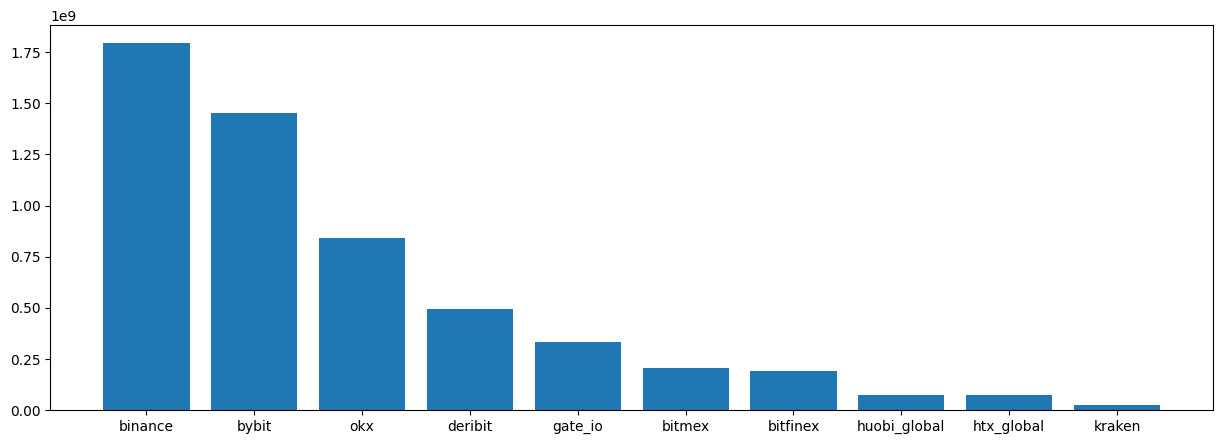

In [49]:
x = interest2.groupby('exchange')['value'].mean().reset_index()
x = x[x.exchange != 'all_exchange']
x = x.sort_values('value', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(x = 'exchange', height='value', data =x)

2. symbol별 open interest mean

<BarContainer object of 4 artists>

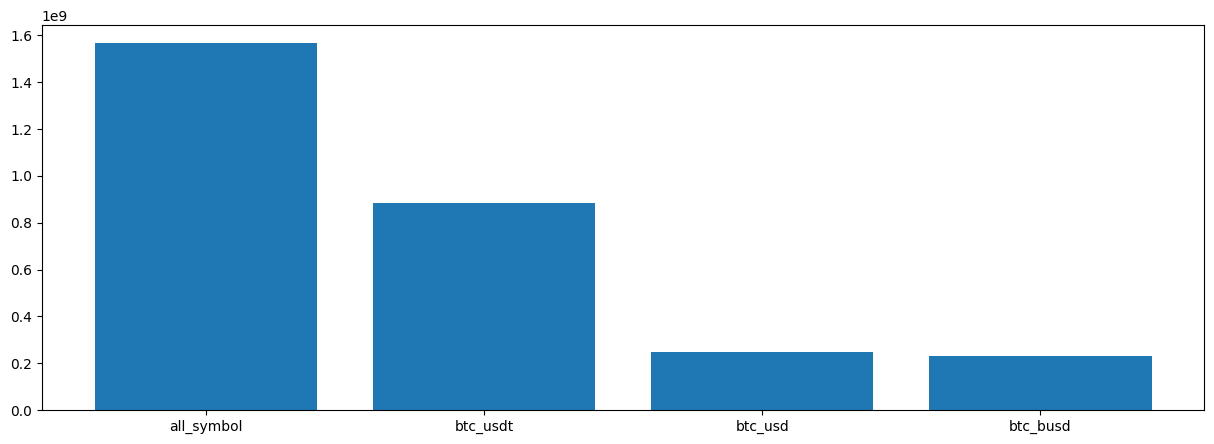

In [50]:
x = interest2.groupby('symbol')['value'].mean().reset_index()
x = x.sort_values('value', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(x = 'symbol', height='value', data =x)

3. exchange - target 별 open interest mean
    - target별로 크게 다르지 않은 듯

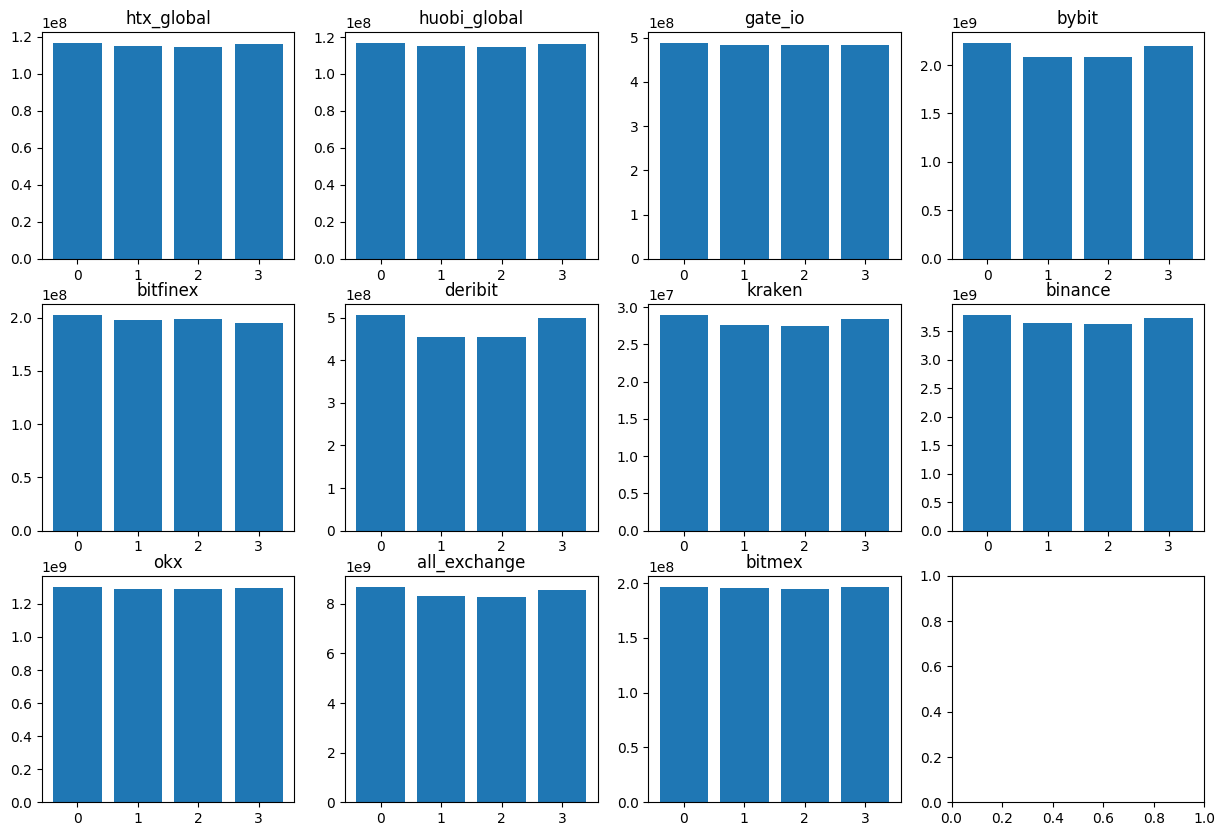

In [51]:
exchange_lst = interest2.exchange.unique().tolist()

fig, axes = plt.subplots(3,4, figsize = (15,10))
for i, ax in enumerate(axes.flat):
    if i == 11 : break
    x = interest2[(interest2.exchange == exchange_lst[i]) & (interest2.symbol == 'all_symbol')]
    x = x.groupby('target')['value'].median().reset_index()
    ax.bar(x='target', height = 'value', data = x)
    ax.set_title(exchange_lst[i])

4. symbol - target 별 open interest mean
    - 크게 달라보이지는 않음

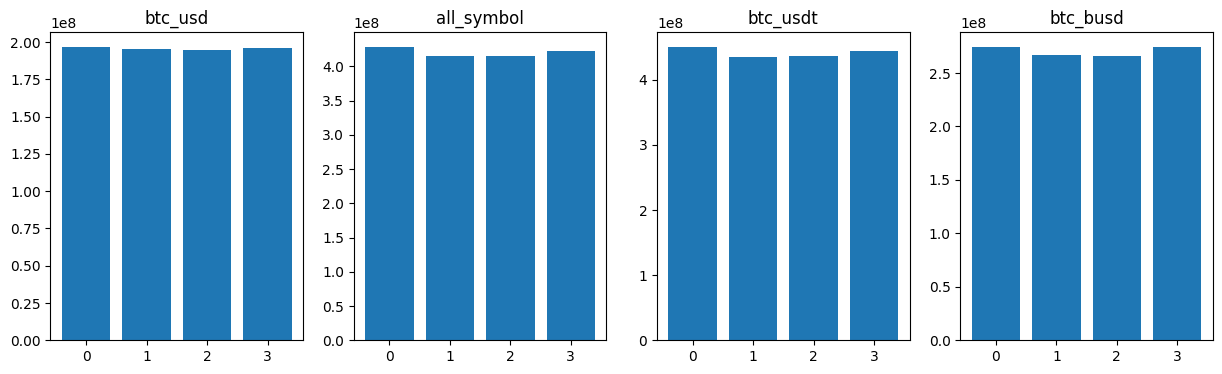

In [52]:
symbol_lst = interest2.symbol.unique().tolist()

fig, axes = plt.subplots(1,4, figsize = (15,4))
for i, ax in enumerate(axes.flat):
    if i == 5 : break
    x = interest2[interest2.symbol == symbol_lst[i]]
    x = x.groupby('target')['value'].median().reset_index()
    ax.bar(x='target', height = 'value', data = x)
    ax.set_title(symbol_lst[i])

### 결론
- all exchange, all symbol 변수만 살리기
- 대단히 유의미한 변수는 찾지 못함

## 5. funding-rates 탐색

 | endpoint                 | description                                                                                     |
  | ------------------------ | ----------------------------------------------------------------------------------------------- |
  | FUNDING-RATES            | 펀딩 비율은 파생 상품 거래에서 사용되며,                                                                  |
  |                          | 이는 보유 중인 포지션에 대한 이자 또는 보유 중인 포지션에 대한 수수료를 결정하는 데 사용됩니다.                        |
  |                          | 시장에 공매수가 많으면 가격이 계속 올라가는데 이를 막기 위해 공매수를 건사람이 공매도를 한 사람한테                      |
  |                          | 주기적으로(8시간에 한번) 돈을 주도록 하는 패널티를 부가합니다.                                                  |
  |                          | 가격이 무한정으로 올라가는 것을 방지합니다.                                                                |
  |                          | 쉽게 “롱(매수)에 건 트레이더가 숏(매도)에 건 트레이더에게 몇%의 비율로 8시간에 한번씩 돈을 주는가?” 라고 생각하면 됩니다.  |

In [109]:
funding = df.loc[:,df.columns.str.contains('hourly_market-data_funding-rates').tolist()]
funding = pd.concat([df[['ID','target', col]],funding], axis = 1)

funding2 = funding.drop(columns = col).melt(id_vars = ['ID','target'])
funding2

ID  target  \
0      2023-01-01 00:00:00     2.0   
1      2023-01-01 01:00:00     1.0   
2      2023-01-01 02:00:00     1.0   
3      2023-01-01 03:00:00     1.0   
4      2023-01-01 04:00:00     2.0   
...                    ...     ...   
92411  2024-04-26 03:00:00     NaN   
92412  2024-04-26 04:00:00     NaN   
92413  2024-04-26 05:00:00     NaN   
92414  2024-04-26 06:00:00     NaN   
92415  2024-04-26 07:00:00     NaN   

                                                variable     value  
0      hourly_market-data_funding-rates_all_exchange_...  0.005049  
1      hourly_market-data_funding-rates_all_exchange_...  0.005049  
2      hourly_market-data_funding-rates_all_exchange_...  0.005049  
3      hourly_market-data_funding-rates_all_exchange_...  0.005067  
4      hourly_market-data_funding-rates_all_exchange_...  0.006210  
...                                                  ...       ...  
92411  hourly_market-data_funding-rates_okx_funding_r...       NaN  
92412  hourly_market-data_funding-rates_okx_funding_r...       NaN  
92413  hourly_market-data_funding-rates_okx_funding_r...       NaN  
92414  hourly_market-data_funding-rates_okx_funding_r...       NaN  
92415  hourly_market-data_funding-rates_okx_funding_r...       NaN  

[92416 rows x 4 columns]

### Correlation plot
- all exchange와 다른 거래소들 간의 상관성이 전반적으로 높은 편 

-> all exchange로 퉁쳐도 괜찮을 듯?

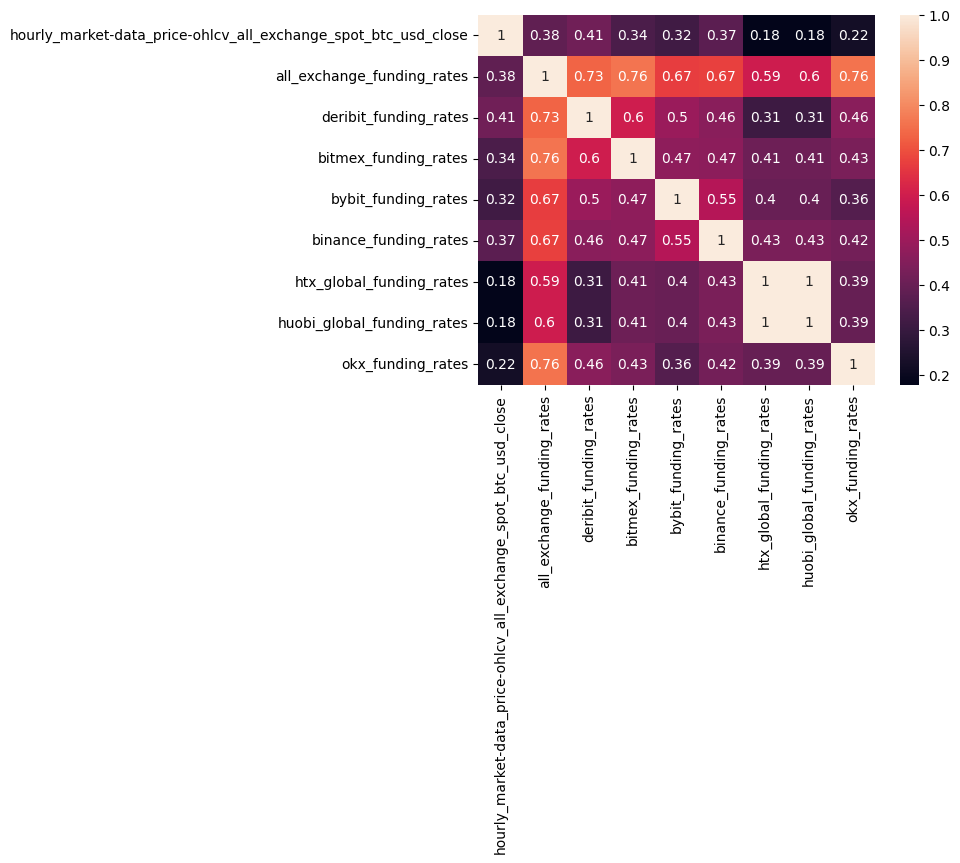

In [110]:
x = funding[funding.ID < '2024-01-01'].drop(columns = ['target', 'ID'])
x.columns = [c.replace("hourly_market-data_funding-rates_", "") for c in x.columns]
corr_matrix = x.corr('spearman')

sns.heatmap(corr_matrix, annot=True)
plt.show()

In [67]:
import re
exchanges_pattern = r"binance|bitfinex|bybit|deribit|ftx|htx_global|huobi_global|okex|okx|bitmex|gate_io|kraken|all_exchange"

funding2['exchange'] = funding2['variable'].apply(lambda x : ''.join(re.findall(exchanges_pattern, x)))

funding2 = funding2.sort_values(by = 'ID')
funding2.drop(columns = 'variable', inplace = True)
funding2 = funding2[funding2.ID < '2024-01-01']
funding2

ID  target     value      exchange
0      2023-01-01 00:00:00     2.0  0.005049  all_exchange
46208  2023-01-01 00:00:00     2.0  0.010000       binance
34656  2023-01-01 00:00:00     2.0  0.010000         bybit
69312  2023-01-01 00:00:00     2.0  0.010000  huobi_global
23104  2023-01-01 00:00:00     2.0  0.001400        bitmex
...                    ...     ...       ...           ...
89623  2023-12-31 23:00:00     2.0  0.041837           okx
31863  2023-12-31 23:00:00     2.0  0.018500        bitmex
54967  2023-12-31 23:00:00     2.0  0.039306       binance
78071  2023-12-31 23:00:00     2.0  0.064891  huobi_global
8759   2023-12-31 23:00:00     2.0  0.037049  all_exchange

[70080 rows x 4 columns]

1. exchange별 fundin rate mean
    - global 거래소가 제일 많네

<BarContainer object of 7 artists>

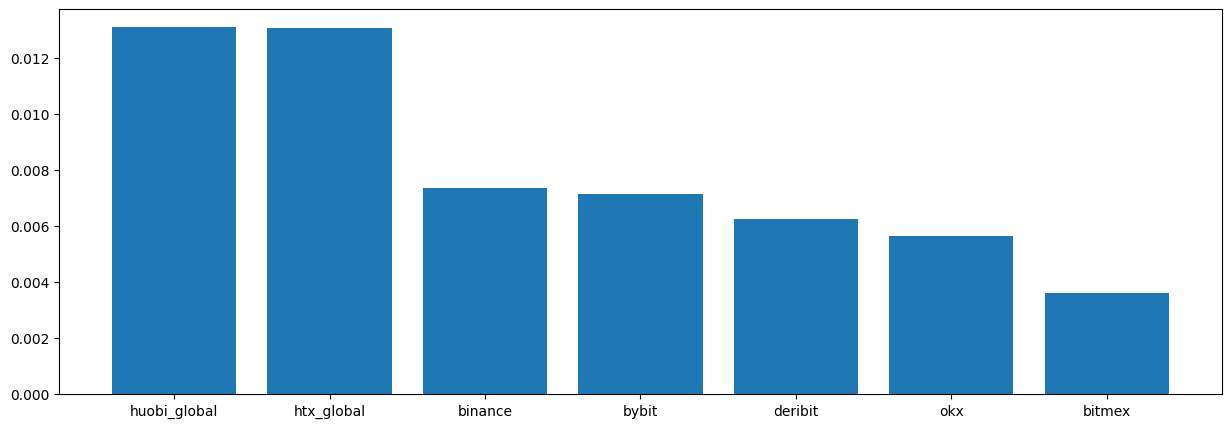

In [68]:
x = funding2.groupby('exchange')['value'].mean().reset_index()
x = x[x.exchange != 'all_exchange']
x = x.sort_values('value', ascending=False)
plt.figure(figsize=(15,5))
plt.bar(x = 'exchange', height='value', data =x)

2. target별 funding rate mean
    - bitmex가 0,3/1,2가 좀 구분되는 듯

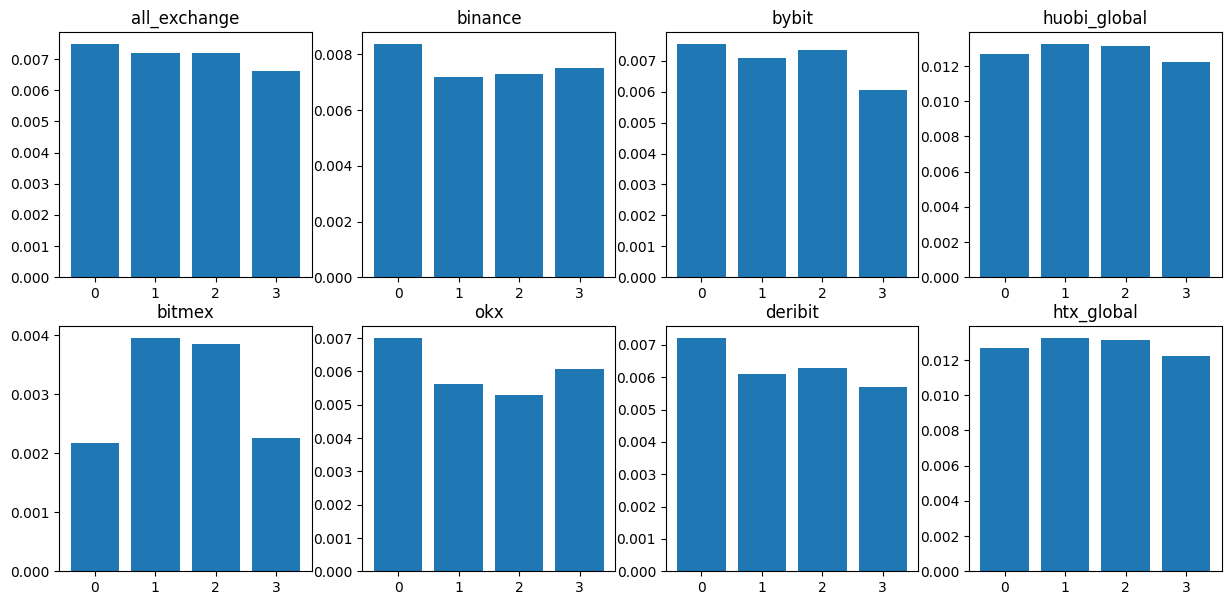

In [69]:
exchange_lst = funding2.exchange.unique().tolist()

fig, axes = plt.subplots(2,4, figsize = (15,7))
for i, ax in enumerate(axes.flat):
    x = funding2[funding2.exchange == exchange_lst[i]]
    x = x.groupby('target')['value'].mean().reset_index()
    ax.bar(x='target', height = 'value', data = x)
    ax.set_title(exchange_lst[i])

In [70]:
# 64%가 0.01이다.
(df["hourly_market-data_funding-rates_huobi_global_funding_rates"] == 0.01).sum()/len(df)

0.6407548476454293

<Axes: xlabel='hourly_market-data_funding-rates_huobi_global_funding_rates', ylabel='Density'>

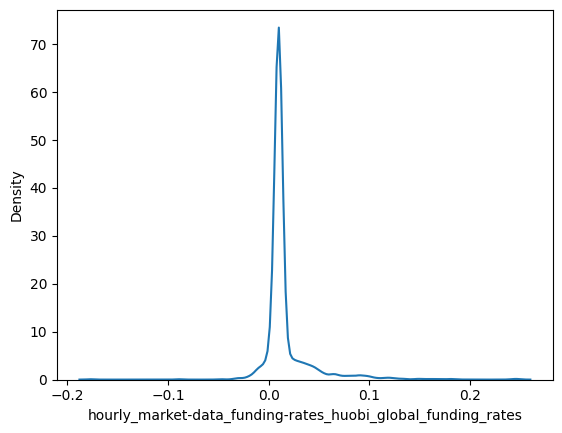

In [71]:
sns.kdeplot(df["hourly_market-data_funding-rates_huobi_global_funding_rates"])

### 결론
- all exchange를 기본 변수로 사용
- exchange 일부 추가
    - funding rate : bitmex

## 6. network data 탐색

  | endpoint           | description                                        |
  |--------------------|----------------------------------------------------|
  | ADDRESSES-COUNT    | 블록체인에서 사용되는 주소의 총 수를 나타냅니다.               |
  | BLOCK-BYTES        | 블록의 크기를 바이트 단위로 나타냅니다.                      |  
  | BLOCK-COUNT        | 블록체인에 현재 저장된 블록의 총 수를 나타냅니다.              |
  | BLOCK-INTERVAL     | 블록 간의 평균 시간 간격을 나타냅니다.                      |
  | BLOCKREWARD        | 채굴자에게 새로운 블록을 추가할 때 지급되는 보상을 나타냅니다.    |
  | DIFFICULTY         | 채굴 난이도를 나타내며, 채굴에 필요한 계산 작업의 양을 나타냅니다. |
  | FEES               | 거래 수수료의 총액을 나타냅니다.                           |
  | FEES-TRANSACTION   | 개별 거래에서 발생한 수수료를 나타냅니다.                    |
  | HASHRATE           | 블록체인 네트워크에서 수행되는 해시 작업의 속도를 나타냅니다.     |
  | SUPPLY             | 현재 블록체인에서 존재하는 총 암호화폐 공급량을 나타냅니다.       |
  | TOKENS-TRANSFERRED | 거래 중에 전송된 토큰의 총 수를 나타냅니다.                   | 
  | TRANSACTIONS-COUNT | 특정 기간 동안 발생한 전체 거래 수를 나타냅니다.              |
  | UTXO-COUNT         | 사용되지 않은 거래 출력의 총 수를 나타냅니다.                |
  | VELOCITY           | 블록체인 네트워크에서 전송되는 자산의 속도를 나타냅니다.         |

| TABLE_NAME                                             | COLUMN_NAME               | 의미                                          |
|--------------------------------------------------------|---------------------------|----------------------------------------------|
| 모든 테이블                                               | datetime                  | 데이터가 쌓인 시간                                |
| ADDRESSES-COUNT                    | addresses_count_active    | 고유한 활성 주소의 총 수, 발신자와 수신자를 모두 포함함   |
| ADDRESSES-COUNT                    | addresses_count_sender    | 발신자로서 활동한 주소의 수                         |
| ADDRESSES-COUNT                    | addresses_count_receiver  | 수신자로서 활동한 주소의 수                         |
| BLOCK-BYTES                        | block_bytes               | 생성된 모든 블록의 평균 크기(바이트)                 |
| BLOCK-COUNT                        | block_count               | 주어진 시간대에 생성된 블록의 수                    |
| BLOCK-INTERVAL                     | block_interval            | 생성된 블록 사이의 평균 시간(초)                    |
| BLOCKREWARD                        | blockreward               | 보상의 총합(마이닝 또는 스테이킹 보상 및 거래 수수료 포함)|
| DIFFICULTY                         | difficulty                | 새로운 블록을 마이닝하는 데 필요한 평균 난이도          |
| FEES-TRANSACTION                   | fees_transaction_mean     | 거래당 평균 수수료                               |
| FEES-TRANSACTION                   | fees_transaction_median   | 거래당 중앙값 수수료                              |
| FEES                               | fees_block_mean           | 블록당 평균 수수료                               |
| FEES                               | fees_total                | 코인 마이너들에게 지불된 모든 수수료의 합계            |
| FEES                               | fees_reward_percent       | 총 블록 보상 중 수수료의 백분율, 값은 0과 1 사이      |
| HASHRATE                           | hashrate                  | 네트워크 내 모든 채굴자들이 초당 계산하는 해시의 평균     |
| SUPPLY                             | supply_total              | 코인의 총 공급량                                 |
| SUPPLY                             | supply_new                | 새로 발행된 코인의 총합                           |
| TOKENS-TRANSFERRED                 | tokens_transferred_total  | 전송된 코인의 총 수                               |
| TOKENS-TRANSFERRED                 | tokens_transferred_mean   | 거래당 전송된 코인의 평균                          |
| HTOKENS-TRANSFERRED                 | tokens_transferred_median | 거래당 전송된 코인의 중앙값                         |
| TRANSACTIONS-COUNT                 | transactions_count_total  | 전송된 토큰의 이체 여부에 관계없이 총 거래 수           |
| TRANSACTIONS-COUNT                 | transactions_count_mean   | 블록당 평균 거래 수                               |
| UTXO-COUNT                         | utxo_count                | 특정 지점에서 존재하는 사용되지 않은 거래 출력의 총 수     |
| VELOCITY                           | velocity_supply_total     | 네트워크에서 전송되는 자산의 속도                     |


In [165]:
network = df.loc[:,df.columns.str.contains('hourly_network-data').tolist()]
network = pd.concat([df[['ID','target', col]],network], axis = 1)
network.columns = [x.replace('hourly_network-data_', '') for x in network.columns]

network2 = network.drop(columns = col).melt(id_vars = ['ID','target'])
network2

ID  target                        variable      value
0       2023-01-01 00:00:00     2.0            fees_fees_block_mean   0.046753
1       2023-01-01 01:00:00     1.0            fees_fees_block_mean   0.064062
2       2023-01-01 02:00:00     1.0            fees_fees_block_mean   0.039122
3       2023-01-01 03:00:00     1.0            fees_fees_block_mean   0.043966
4       2023-01-01 04:00:00     2.0            fees_fees_block_mean   0.049267
...                     ...     ...                             ...        ...
323451  2024-04-26 03:00:00     NaN  velocity_velocity_supply_total  15.708903
323452  2024-04-26 04:00:00     NaN  velocity_velocity_supply_total  15.709585
323453  2024-04-26 05:00:00     NaN  velocity_velocity_supply_total  15.709207
323454  2024-04-26 06:00:00     NaN  velocity_velocity_supply_total  15.710891
323455  2024-04-26 07:00:00     NaN  velocity_velocity_supply_total  15.710484

[323456 rows x 4 columns]

### Correlation plot

전반적으로 상관성이 높은 변수들이 많음
- difficulty, supply_total, velocity_supply_total, utxo_count 이 상관성 높음 
- xxx와 xxx_usd 의 상관성이 거의 1 -> 둘 중 하나 고르기

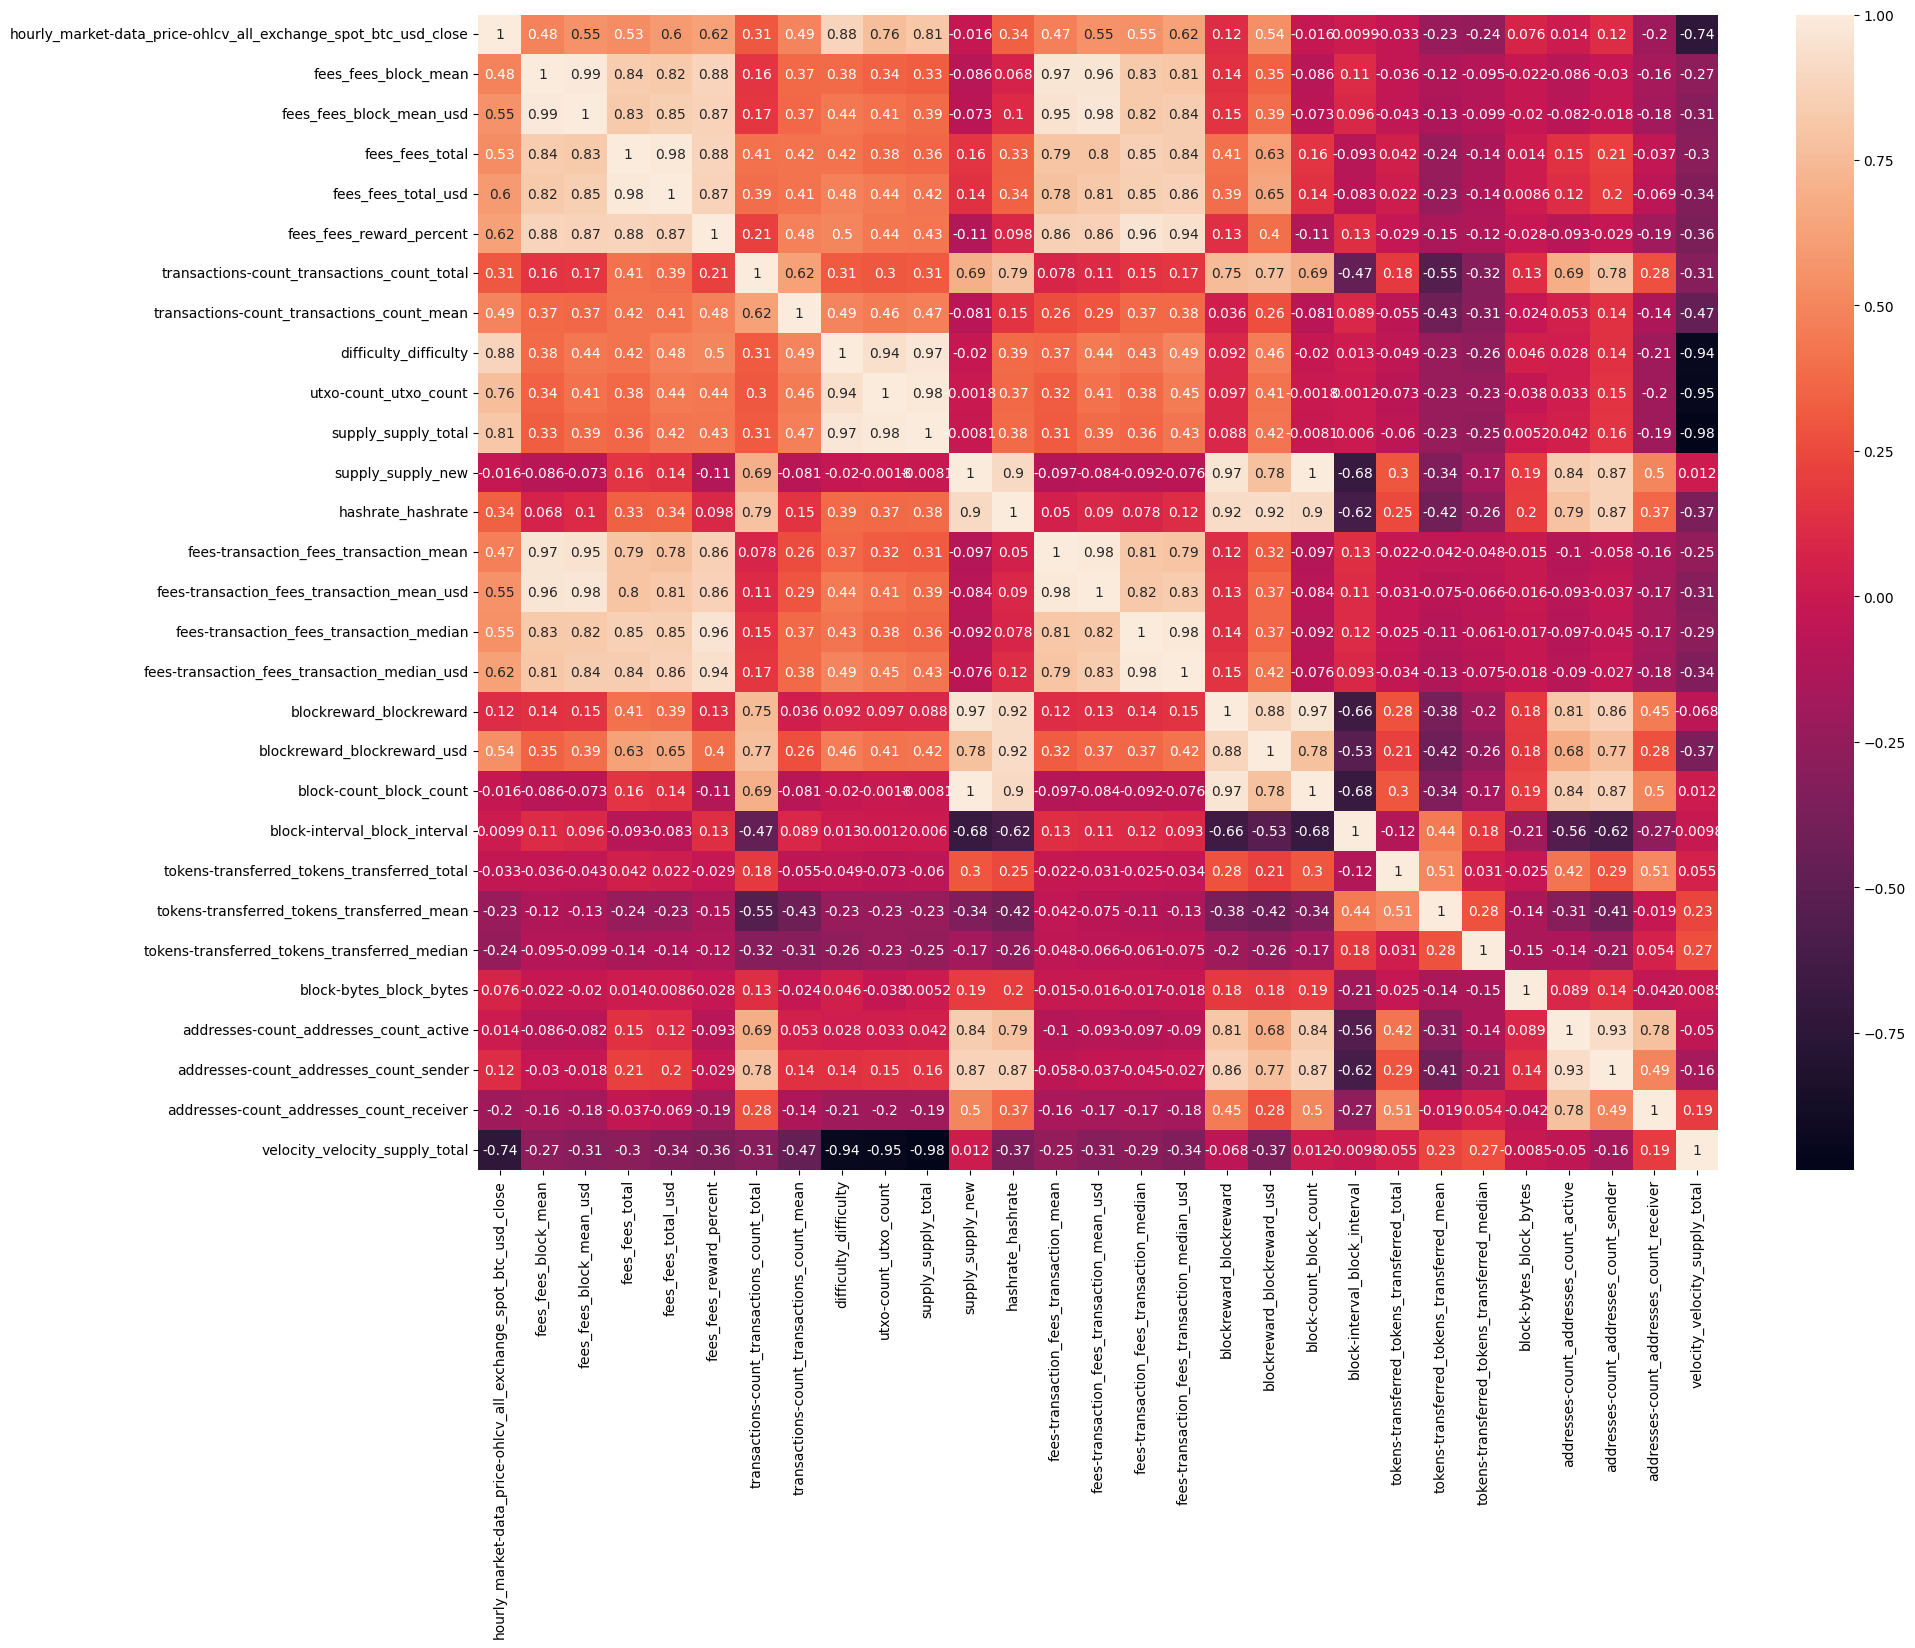

In [168]:
x = network[network.ID < '2024-01-01'].drop(columns = ['target', 'ID'])

corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

1. target별 network data 변수 mean
    - target 별로 엄청나게 달라보이지는 않음

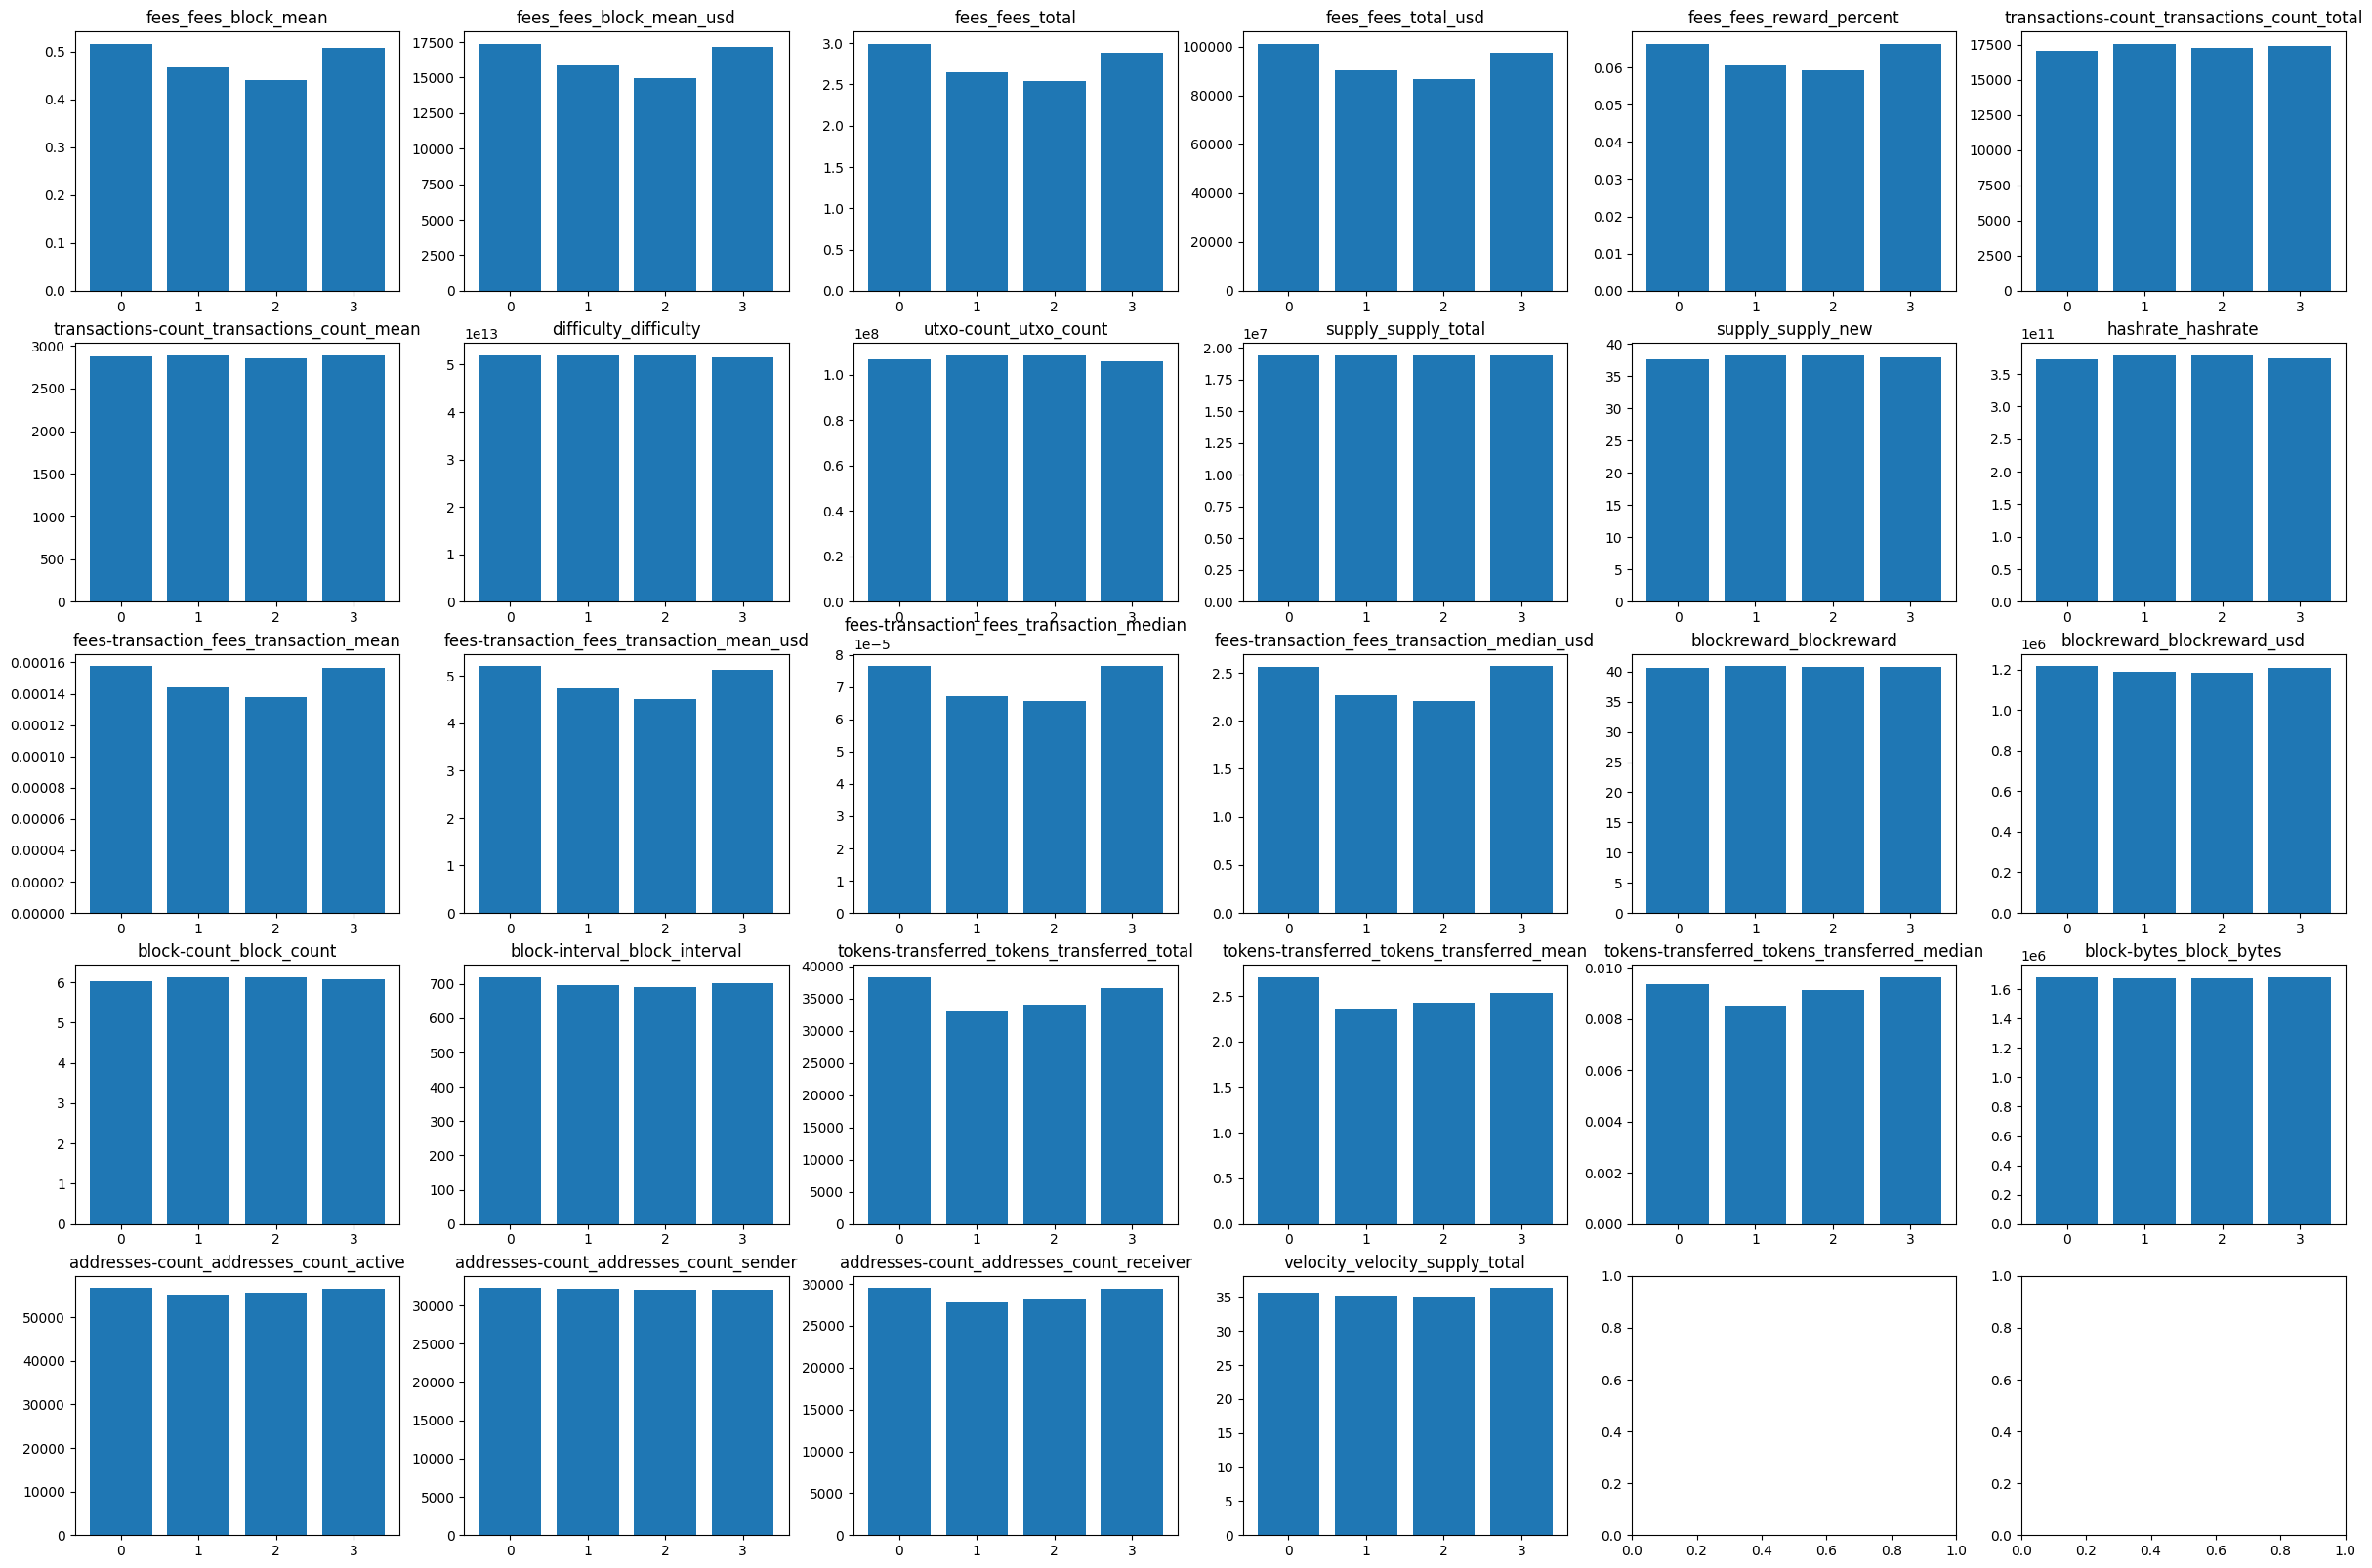

In [176]:
variable_lst = network2.variable.unique().tolist()

fig, axes = plt.subplots(5,6, figsize = (30,20))
for i, ax in enumerate(axes.flat):
    if i == 28: break
    x = network2[network2.variable == variable_lst[i]]
    x = x.groupby('target')['value'].mean().reset_index()
    ax.bar(x='target', height = 'value', data = x)
    ax.set_title(variable_lst[i])

2. target 별 addresses diff mean
    - addresses_count_sender - addresses_count_receiver
    - 그냥 sender, receiver 변수보다 target에 따른 차이가 더 명확하게 나타남

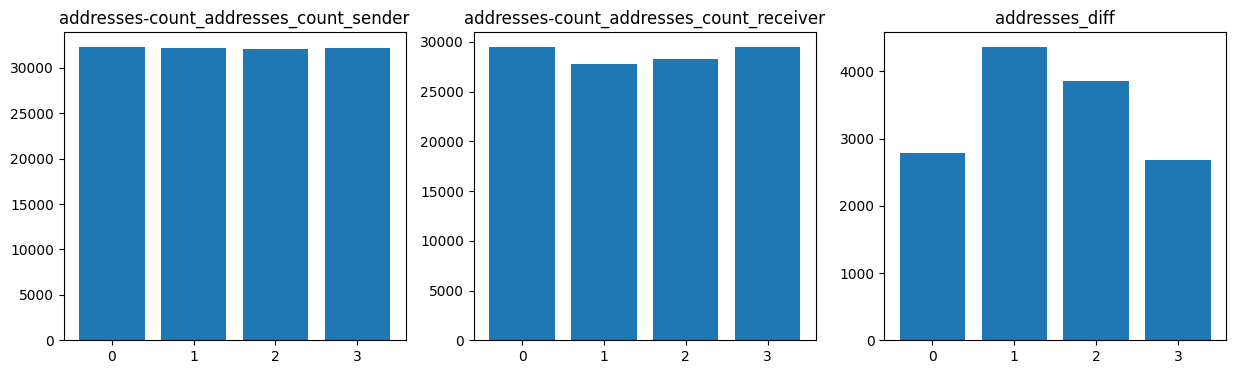

In [182]:
network['addresses_diff'] =  network["addresses-count_addresses_count_sender"] - network["addresses-count_addresses_count_receiver"]
network2 = network.drop(columns = col).melt(id_vars = ['ID','target'])

variable_lst = ["addresses-count_addresses_count_sender", "addresses-count_addresses_count_receiver", 'addresses_diff']

fig, axes = plt.subplots(1,3, figsize = (15,4))
for i, ax in enumerate(axes.flat):
    if i == 28: break
    x = network2[network2.variable == variable_lst[i]]
    x = x.groupby('target')['value'].mean().reset_index()
    ax.bar(x='target', height = 'value', data = x)
    ax.set_title(variable_lst[i])

### 결론
- 일단 모든 변수 추가하고 나중에 변수 선택 필요
- 파생변수 생성
    - address_diff

# 파생변수
비트코인 가격 예측을 위한 상호작용 및 새로운 Feature 제안
1. 시장 압력 지수

- 계산: (taker_buy_ratio * open_interest) / (taker_sell_ratio * funding_rates)
- 의미: 매수 압력과 매도 압력의 균형을 나타내는 복합 지표
- 해석: 높은 값은 강한 매수 압력, 낮은 값은 강한 매도 압력을 의미

2. 네트워크 활성화 효율성

- 계산: (addresses_count_active * transactions_count_total) / (block_interval * block_bytes)
- 의미: 네트워크의 사용 효율성을 나타내는 지표
- 해석: 높은 값은 네트워크가 효율적으로 많은 거래를 처리하고 있음을 의미

3. HODLer 신뢰 지수

- 계산: (utxo_count * difficulty) / (velocity_supply_total * supply_new)
- 의미: 장기 보유자들의 신뢰도와 새로운 공급의 압력을 비교하는 지표
- 해석: 높은 값은 강한 HODLing 경향과 낮은 인플레이션 압력을 의미

4. 채굴자 수익성 지수

- 계산: (blockreward * hashrate) / (difficulty * fees_total)
- 의미: 채굴자들의 전반적인 수익성을 나타내는 지표
- 해석: 높은 값은 채굴이 수익성이 높다는 것을 의미하며, 이는 장기적으로 네트워크 보안에 긍정적

5. 기관 투자 유입 지수

- 계산: coinbase_premium_index * (tokens_transferred_mean / tokens_transferred_median)
- 의미: 기관 투자자들의 시장 참여도를 나타내는 지표
- 해석: 높은 값은 기관 투자자들의 강한 매수세를 의미

6. 레버리지 위험 지수

- 계산: (long_liquidations + short_liquidations) * open_interest / (addresses_count_active * tokens_transferred_total)
- 의미: 시장의 레버리지 사용 정도와 그에 따른 위험을 나타내는 지표
- 해석: 높은 값은 시장이 과도한 레버리지로 인해 변동성이 커질 수 있음을 의미

7. 온체인 활동 대비 가격 괴리도

- 계산: (market_price * supply_total) / (transactions_count_total * tokens_transferred_total)
- 의미: 현재 가격이 온체인 활동에 비해 고평가 또는 저평가되었는지를 나타내는 지표
- 해석: 높은 값은 온체인 활동 대비 가격이 고평가되었을 가능성을 의미

8. 네트워크 성장 대비 수수료 부담 지수

- 계산: (fees_transaction_mean * transactions_count_total) / (addresses_count_active * supply_new)
- 의미: 네트워크의 성장과 사용자들의 수수료 부담 사이의 균형을 나타내는 지표
- 해석: 높은 값은 네트워크 사용 비용이 증가하고 있음을 의미하며, 이는 장기적으로 채택에 부정적일 수 있음

9. 시장 건전성 지수

- 계산: (hashrate * addresses_count_active) / (long_liquidations + short_liquidations)
- 의미: 네트워크의 보안과 사용자 기반 대비 투기적 거래의 비중을 나타내는 지표
- 해석: 높은 값은 시장이 더 건전하고 안정적임을 의미

10. 거래소 중앙화 위험 지수

- 계산: (tokens_transferred_total - tokens_transferred_mean * transactions_count_total) / utxo_count
- 의미: 대량 거래가 거래소로 집중되는 정도를 나타내는 지표
- 해석: 높은 값은 거래가 소수의 거래소에 집중되어 있음을 의미하며, 이는 중앙화 위험을 나타냄

11. 청산 비율
- 계산 : liquidation / open-interest
- 의미 : 전체 포지션 대비 청산된 포지션의 비율

12. 청산 대비 거래량 비율
- 계산 : liquidation / (taker-buy + taker-sell)
- 의미 : 전체 거래량 중 청산이 차지하는 비중

13. 거래량 대비 오픈 인터레스트 비율
- 계산 : (taker-buy + taker-sell) / open-interest
- 의미 : 거래 활성도와 포지션 유지 정도를 비교

In [93]:
def make_df(df):
    # 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
    cols_dict: Dict[str, str] = {
        "ID": "ID",
        "target": "target",
        "_type": "_type",
        # coinbase
        "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
        "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
        # funding_rate
        "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates",
        
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates_bitmex",
        # liquidations
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
        
        "hourly_market-data_liquidations_bybit_all_symbol_long_liquidations": "long_liquidations_bybit",
        "hourly_market-data_liquidations_bybit_all_symbol_short_liquidations": "short_liquidations_bybit",
        "hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations": "long_liquidations_bitfinex",
        "hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations": "short_liquidations_bitfinex",
        "hourly_market-data_liquidations_binance_all_symbol_long_liquidations": "long_liquidations_binance",
        "hourly_market-data_liquidations_binance_all_symbol_short_liquidations": "short_liquidations_binance",
        
        # open-interest
        "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
        
        # taker_buy_sell
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
        
        'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_buy_sell_ratio' : "buy_sell_ratio_huobi",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume": "buy_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume": "sell_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume": "buy_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume": "sell_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume": "buy_volume_okx",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume": "sell_volume_okx",
        
        # address
        "hourly_network-data_addresses-count_addresses_count_active": "active_count",
        "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
        "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
        
        # transactions_count
        'hourly_network-data_transactions-count_transactions_count_total' : "transactions_count_total",
        'hourly_network-data_transactions-count_transactions_count_mean' : "transactions_count_mean",
        
        # fees_block
        'hourly_network-data_fees_fees_block_mean' : "block_mean",
        'hourly_network-data_fees_fees_block_mean_usd' : "block_mean_usd",
        
        # fees
        'hourly_network-data_fees_fees_total' : 'fees_total',
        'hourly_network-data_fees_fees_total_usd' : 'fees_total_usd',
        'hourly_network-data_fees_fees_reward_percent' : 'fees_reward_percent',
        
        # difficulty
        'hourly_network-data_difficulty_difficulty' : 'difficulty',
        
        # utxo
        'hourly_network-data_utxo-count_utxo_count' : 'utxo_count',
        
        # supply
        'hourly_network-data_supply_supply_total' : 'supply_total',
        'hourly_network-data_supply_supply_new' : 'supply_new',
        
        # hashrate
        'hourly_network-data_hashrate_hashrate' : 'hashrate',
        
        # fees_transaction
        'hourly_network-data_fees-transaction_fees_transaction_mean' : 'fees_transaction_mean',
        'hourly_network-data_fees-transaction_fees_transaction_mean_usd' : 'fees_transaction_mean_usd',
        'hourly_network-data_fees-transaction_fees_transaction_median' : 'fees_transaction_median',
        'hourly_network-data_fees-transaction_fees_transaction_median_usd' : 'fees_transaction_median_usd',
        
        # blockreward
        'hourly_network-data_blockreward_blockreward' : 'blockreward',
        'hourly_network-data_blockreward_blockreward_usd' : 'blockreward_usd',
        'hourly_network-data_block-interval_block_interval' : 'block_interval',
        
        # transffered_tokens
        'hourly_network-data_tokens-transferred_tokens_transferred_total' : 'tokens_transferred_total',
        'hourly_network-data_tokens-transferred_tokens_transferred_mean' : 'tokens_transferred_mean',
        'hourly_network-data_tokens-transferred_tokens_transferred_median' : 'tokens_transferred_median',
        
        # block_bytes
        'hourly_network-data_block-bytes_block_bytes' : 'block_bytes',
        
        # velocity
        'hourly_network-data_velocity_velocity_supply_total' : 'velocity_supply_total',
        
        # close
        'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close' : 'close'
        
    }
    df2 = df[cols_dict.keys()].rename(cols_dict, axis=1)
    return df2, cols_dict
    

In [109]:
df2, cols_dict = make_df(df)

## 결측치 처리
- ccf 보려면 na가 없어야 해서 mice로 대강 결측치 처리

In [110]:
train_df = df2[df2._type == 'train'].drop(columns = ['_type', 'target', 'ID', 'close'])
train_df.head()

coinbase_premium_gap  coinbase_premium_index  funding_rates  \
0                 -9.86               -0.059650       0.005049   
1                 -8.78               -0.053047       0.005049   
2                 -9.59               -0.057952       0.005049   
3                 -9.74               -0.058912       0.005067   
4                -10.14               -0.061373       0.006210   

   funding_rates_bitmex  long_liquidations  long_liquidations_usd  \
0              0.001400              0.012              197.51610   
1              0.001400              0.000                0.00000   
2              0.001400              0.000                0.00000   
3              0.001518              0.593             9754.76891   
4              0.008400              0.361             5944.43714   

   short_liquidations  short_liquidations_usd  long_liquidations_bybit  \
0               0.000                 0.00000                      0.0   
1               0.712             11833.56104                      0.0   
2               0.000                 0.00000                      0.0   
3               0.000                 0.00000                      0.0   
4               0.000                 0.00000                      0.0   

   short_liquidations_bybit  ...  fees_transaction_median  \
0                       0.0  ...                 0.000014   
1                       0.0  ...                 0.000014   
2                       0.0  ...                 0.000014   
3                       0.0  ...                 0.000014   
4                       0.0  ...                 0.000014   

   fees_transaction_median_usd  blockreward  blockreward_usd  block_interval  \
0                     0.235973    75.561037     1.248565e+06      427.333333   
1                     0.237108    25.256248     4.176322e+05      782.500000   
2                     0.234878    50.312978     8.321735e+05      365.125000   
3                     0.234608    31.469829     5.199754e+05      667.800000   
4                     0.237996    44.094866     7.286038e+05      703.000000   

   tokens_transferred_total  tokens_transferred_mean  \
0              33057.024011                 2.885312   
1              12933.965951                 2.217758   
2              26960.250177                 4.857703   
3              32747.924338                 6.243646   
4              26550.999095                 3.824690   

   tokens_transferred_median    block_bytes  velocity_supply_total  
0                   0.020125  783554.416667              65.978971  
1                   0.021293  890760.500000              65.977755  
2                   0.022980  558209.750000              65.975570  
3                   0.024678  640371.800000              65.975092  
4                   0.028596  712739.000000              65.969825  

[5 rows x 54 columns]

In [111]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost

iimp = IterativeImputer(
estimator = xgboost.XGBRegressor(),
random_state = 42,
verbose = 2,
max_iter=15
)

final = iimp.fit_transform(train_df)

[IterativeImputer] Completing matrix with shape (8760, 54)
[IterativeImputer] Ending imputation round 1/15, elapsed time 23.91
[IterativeImputer] Change: 15882020652404.398, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 2/15, elapsed time 48.65
[IterativeImputer] Change: 520794222662.88983, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 3/15, elapsed time 72.30
[IterativeImputer] Change: 235141245206.2908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 4/15, elapsed time 94.39
[IterativeImputer] Change: 358940148733.0492, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 5/15, elapsed time 118.50
[IterativeImputer] Change: 356402674682.4908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 6/15, elapsed time 143.95
[IterativeImputer] Change: 576049998479.4775, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation 

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [112]:
df3 = pd.DataFrame(final, columns = train_df.columns)
df3[['target', 'close']] = df2[df2._type == 'train'][['target', 'close']]

In [113]:
df3.isnull().sum(axis = 0).sort_values()

coinbase_premium_gap           0
coinbase_premium_index         0
funding_rates                  0
funding_rates_bitmex           0
long_liquidations              0
long_liquidations_usd          0
short_liquidations             0
short_liquidations_usd         0
long_liquidations_bybit        0
short_liquidations_bybit       0
long_liquidations_bitfinex     0
short_liquidations_bitfinex    0
long_liquidations_binance      0
short_liquidations_binance     0
open_interest                  0
buy_ratio                      0
buy_sell_ratio                 0
buy_volume                     0
sell_ratio                     0
sell_volume                    0
buy_sell_ratio_huobi           0
buy_volume_deribit             0
sell_volume_deribit            0
buy_volume_bybit               0
sell_volume_bybit              0
buy_volume_okx                 0
sell_volume_okx                0
active_count                   0
receiver_count                 0
sender_count                   0
transactio

## 파생변수 생성

In [114]:
def feature_engineering(df, cols_dict):
    # eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
    epsilon=1e-6
    df2 = df.assign(
        # liquidation
        liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
        liquidation_diff_bybit=df["long_liquidations_bybit"] - df["short_liquidations_bybit"],
        liquidation_index=(df["long_liquidations"] - df["short_liquidations"])/(df["long_liquidations"] + df["short_liquidations"]+ epsilon),
        liquidation_index_bitfinex=(df["long_liquidations_bitfinex"] - df["short_liquidations_bitfinex"])/(df["long_liquidations_bitfinex"] + df["short_liquidations_bitfinex"]+ epsilon),
        liquidation_index_binance=(df["long_liquidations_binance"] - df["short_liquidations_binance"])/(df["long_liquidations_binance"] + df["short_liquidations_binance"]+ epsilon),
        
        # taker buy sell
        volume_diff=df["buy_volume"] - df["sell_volume"],
        volume_diff_deribit=df["buy_volume_deribit"] - df["sell_volume_deribit"],
        volume_diff_bybit=df["buy_volume_bybit"] - df["sell_volume_bybit"],
        volume_diff_okx=df["buy_volume_okx"] - df["sell_volume_okx"],
        volume_index=(df["buy_volume"] - df["sell_volume"])/(df["buy_volume"] + df["sell_volume"]+ epsilon),
        
        # address
        address_diff = df["sender_count"] - df["receiver_count"],
        
        # interaction term
        buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + epsilon),
        long_liquidation_interest_ratio = df["long_liquidations"]/df['open_interest'],
        short_liquidation_interest_ratio = df["short_liquidations"]/df['open_interest'],
        long_liquidation_volume_ratio = df["long_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        short_liquidation_volume_ratio = df["short_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        volume_interest_ratio = (df['buy_volume']+df['sell_volume'])/(df['open_interest']+ epsilon),

        market_pressure = (df['buy_ratio']*df['open_interest']) / (df['sell_ratio']*df['funding_rates']+epsilon),
        network_active = (df['active_count']*df['transactions_count_total'])/(df['block_interval']*df['block_bytes']+epsilon),
        Hodler = (df['utxo_count']*df['difficulty'])/(df['velocity_supply_total']*df['supply_new']+epsilon),
        profitability = (df['blockreward']*df['hashrate'])/(df['difficulty']*df['fees_total']+epsilon),
        investment = df['coinbase_premium_index']*df['tokens_transferred_mean']/(df['tokens_transferred_median']+epsilon),
        leverage = (df['long_liquidations'] + df['short_liquidations'])*df['open_interest']/(df['active_count']*df['tokens_transferred_total']+epsilon),
        fee_index = (df['fees_transaction_mean'] * df['transactions_count_total'])/(df['active_count']*df['supply_new']+epsilon),
        market_health = (df['hashrate']*df['active_count'])/(df['long_liquidations']+df['short_liquidations']+epsilon),
        exchange_center = (df['tokens_transferred_total'] - df['tokens_transferred_mean']*df['transactions_count_total'])/(df['utxo_count']+epsilon),
        
    )
    # category, continuous 열을 따로 할당해둠
    category_cols: List[str] = []
    conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
        "liquidation_diff",
        "liquidation_diff_bybit",
        "liquidation_index",
        "liquidation_index_bitfinex",
        "liquidation_index_binance",
        
        "volume_diff",
        "volume_diff_deribit",
        "volume_diff_bybit",
        "volume_diff_okx",
        "volume_index",
        
        "address_diff",
        
        "buy_sell_volume_ratio",
        "long_liquidation_interest_ratio",
        "short_liquidation_interest_ratio",
        "long_liquidation_volume_ratio",
        "short_liquidation_volume_ratio",
        "volume_interest_ratio",
        
        "market_pressure",
        "network_active",
        "Hodler",
        "profitability",
        "investment",
        "leverage",
        "fee_index",
        "market_health",
        "exchange_center",
    ]
    return df2, category_cols, conti_cols

In [115]:
# 파생 변수 생성에만 필요했던 변수들은 제거
drop_cols = ['long_liquidations_bybit', 'short_liquidations_bybit', 
             'long_liquidations_bitfinex', 'short_liquidations_bitfinex', 
             'long_liquidations_binance', 'short_liquidations_binance',
             'buy_volume_deribit', 'sell_volume_deribit',
             'buy_volume_bybit', 'sell_volume_bybit',
             'buy_volume_okx', 'sell_volume_okx',
             ]

In [116]:
df3, category_cols, conti_cols = feature_engineering(df3, cols_dict)
df3 = df3.drop(columns = drop_cols)

## 막대그래프 시각화
- 나름대로 target 구분이 되는 듯

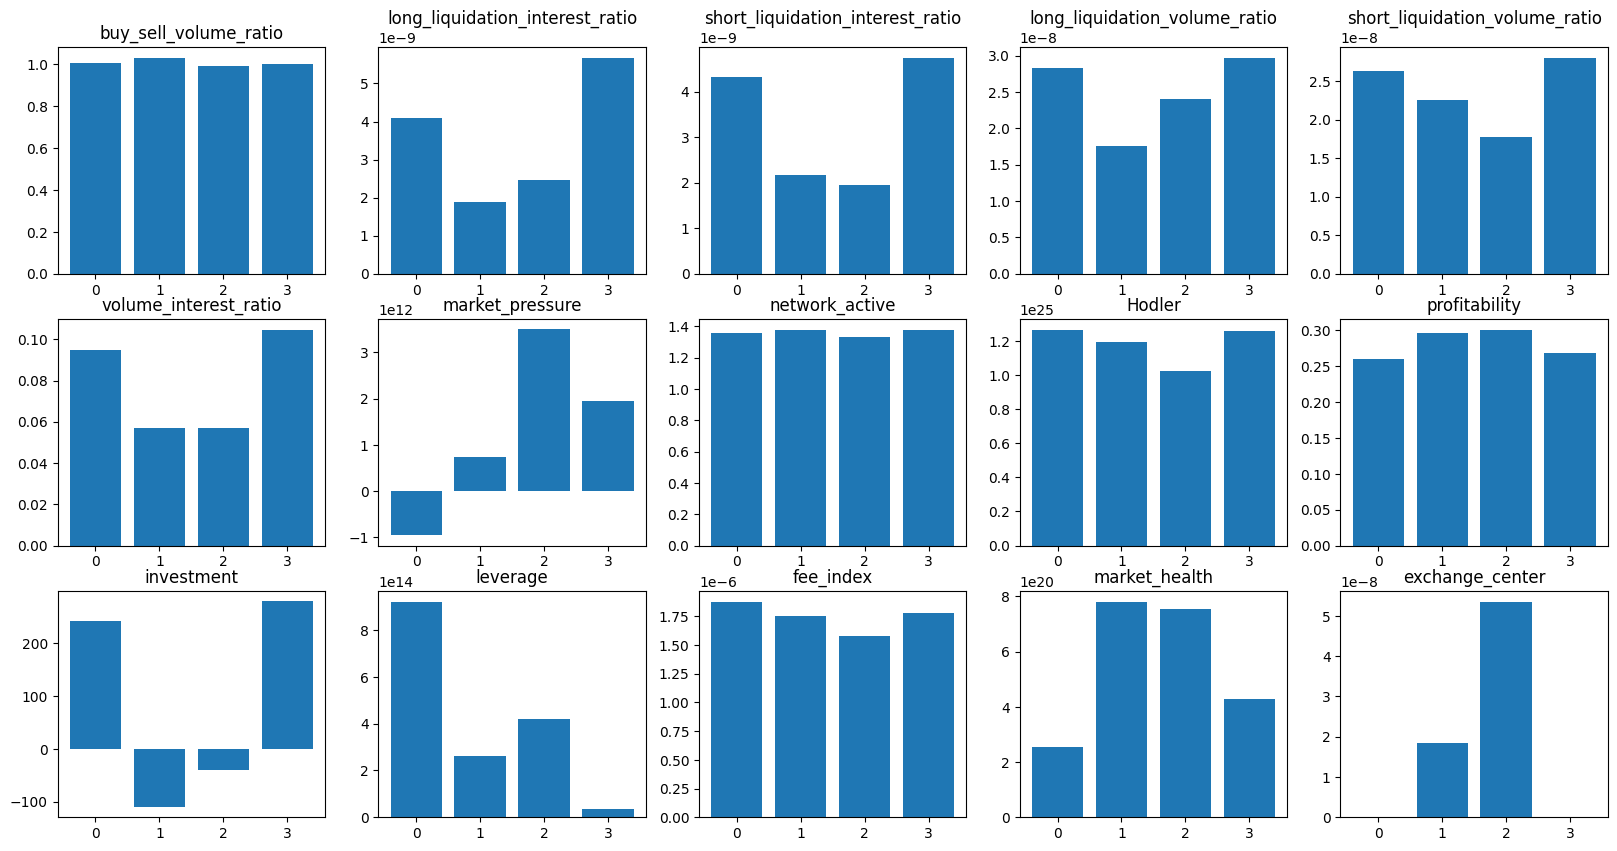

In [119]:
variable_lst = [
    "buy_sell_volume_ratio",
    "long_liquidation_interest_ratio",
    "short_liquidation_interest_ratio",
    "long_liquidation_volume_ratio",
    "short_liquidation_volume_ratio",
    "volume_interest_ratio",
    "market_pressure",
    "network_active",
    "Hodler",
    "profitability",
    "investment",
    "leverage",
    "fee_index",
    "market_health",
    "exchange_center"
]

fig, axes = plt.subplots(3,5, figsize = (20,10))
for i, ax in enumerate(axes.flat):
    x = df3.groupby('target')[variable_lst[i]].mean().reset_index()
    ax.bar(x='target', height = variable_lst[i], data = x)
    ax.set_title(variable_lst[i])

## correlation
- 변수 간의 correlation도 크지 않은 듯

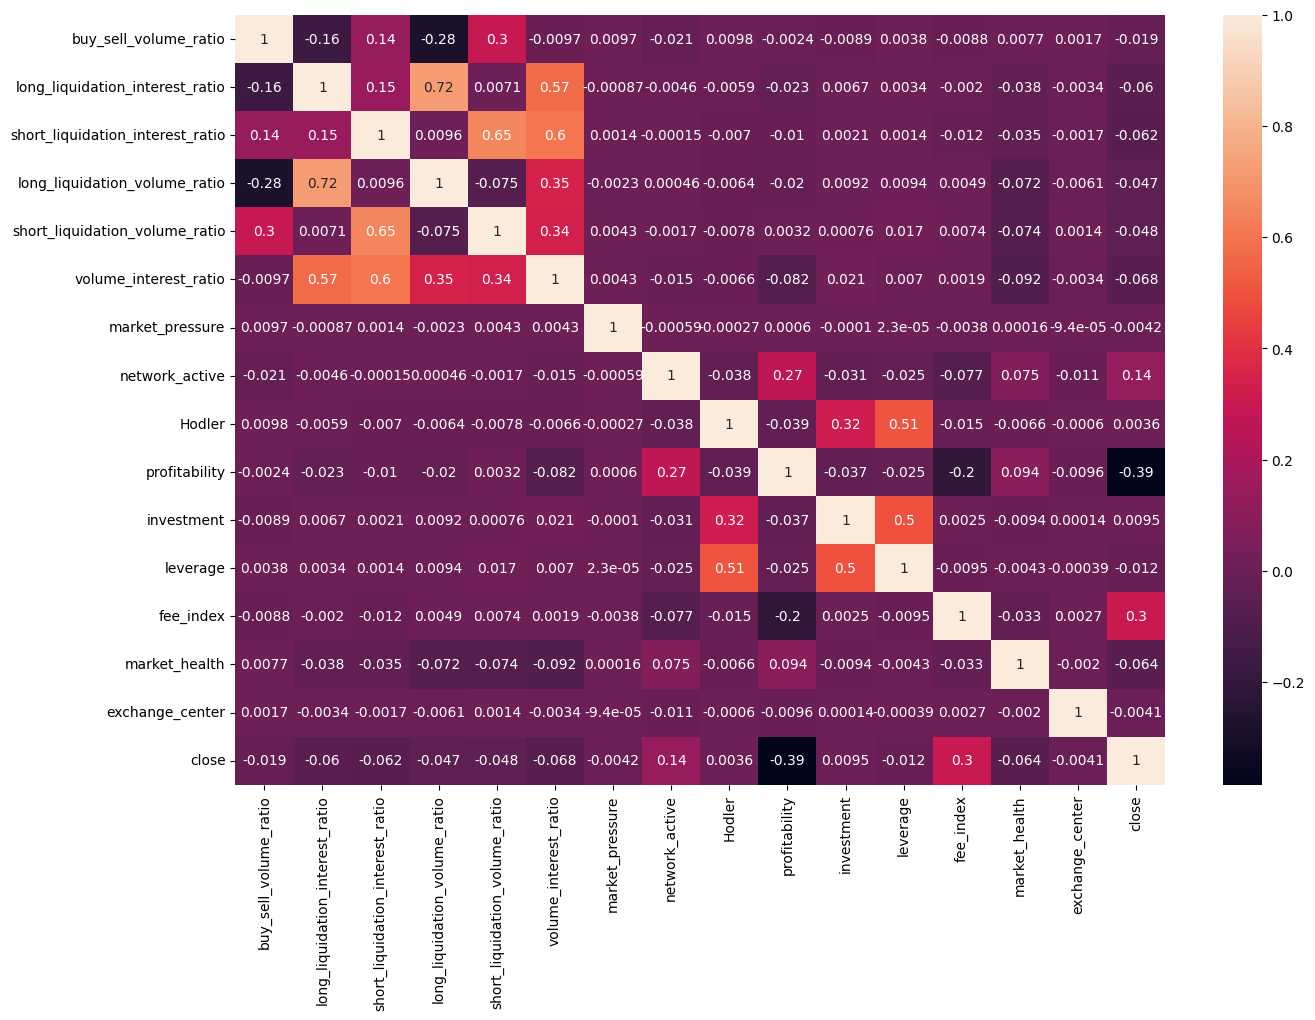

In [121]:
x = df3[variable_lst + ['close']]

corr_matrix = x.corr('pearson')

plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# CCF plot
y(close) 와 x 간의 상관성을 보자. (몇 lag 전까지 상관성이 있을까?)

In [123]:
def create_ccf_grid_plot(data, y_var, x_vars, max_lag=120):
    n_vars = len(x_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle(f'Backward CCF Plots: {y_var} vs Other Variables (Last {max_lag} hours)', fontsize=16)

    for i, x_var in enumerate(x_vars):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        y = data[y_var]
        x = data[x_var]
        
        # ccf value
        ccf_values = ccf(x[::-1], y[::-1], adjusted=False, nlags = max_lag) # backward corr 계산을 위해 [::-1]로 reverse
        lags = range(0,max_lag) 
    
        ax.bar(lags, ccf_values, width=0.3)
        ax.axhline(y=0, color='black', linestyle='-')
        ax.axhline(y=1.96/np.sqrt(max_lag), color='r', linestyle='--')
        ax.axhline(y=-1.96/np.sqrt(max_lag), color='r', linestyle='--')
        
        ax.set_title(f'{y_var} vs {x_var}')
        ax.set_xlabel('Lag (hours)')
        ax.set_ylabel('Cross-Correlation')
        ax.tick_params(axis='x', rotation=45)

    # Remove empty subplots
    for i in range(n_vars, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

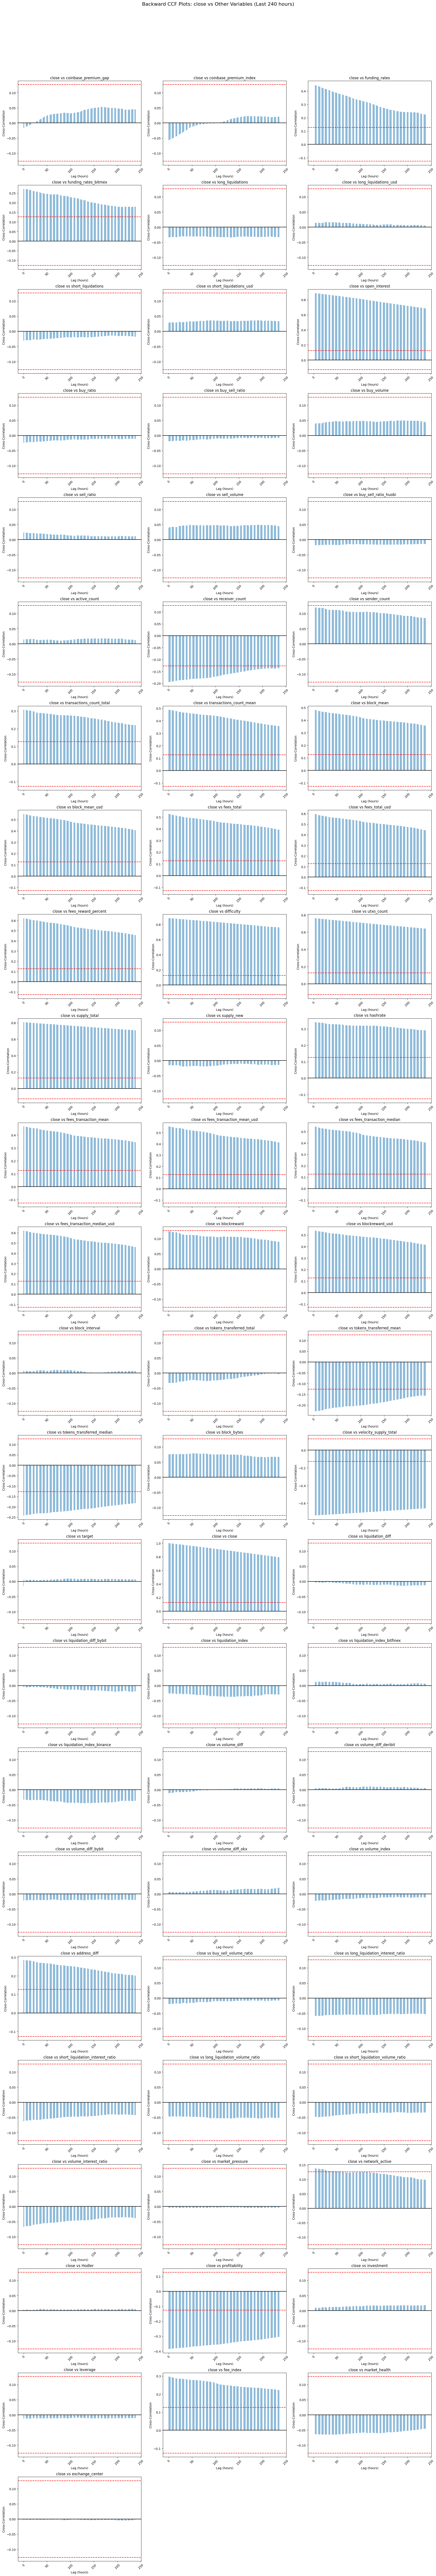

In [124]:
y_var = 'close'
x_vars = df3.columns
ccf_grid = create_ccf_grid_plot(df3, y_var, x_vars, max_lag=240)
plt.show()

상관성 있는 변수
- funding_rates (+bitmex)
- open_interest
- transactions_count_total
- transactions_count_mean
- block_mean
- block_mean_usd  -> block_mean 보다 상관성 높게 나옴 (이것만 남기기)
- fees_total
- fees_total_usd -> fees_total 보다 상관성 높게 나옴 (이것만 남기기)
- fees_reward_percent
- difficulty
- utxo_count
- supply_total
- hashrate
- fees_transaction_mean
- fees_transaction_mean_usd -> fees_transaction_mean 보다 상관성 높게 나옴 (이것만 남기기)
- fees_transaction_median
- fees_transaction_median_usd > fees_transaction_median 보다 상관성 높게 나옴 (이것만 남기기)
- blockreward_usd
- tokens_transferred_mean
- tokens_transferred_median
- velocity_supply_total
- address_diff
- profitability
- fee_index 
